In [2]:
import sys
sys.path.append('/Users/gregmartinez/.local/share/virtualenvs/mtg_scraper-N8QFuhGA/lib/python3.8/site-packages/')

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

In [3]:
from collections import Counter
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from scipy.stats import binom_test, ttest_1samp, chi2_contingency, ttest_ind, f_oneway
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.corpus import wordnet

In [4]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)

In [5]:
# Loads all data saved in flat_files directory
# Data is generated by running main.py and cleaned by running data_cleaning.py

FLAT_FILE_DIR = "../flat_files/"

full_table = pd.read_csv(FLAT_FILE_DIR + "full_table.csv")
event_table = pd.read_csv(FLAT_FILE_DIR + "event_table.csv")
deck_list_table = pd.read_csv(FLAT_FILE_DIR + "deck_list_table.csv")
pilot_table = pd.read_csv(FLAT_FILE_DIR + "pilot_table.csv")
deck_table = pd.read_csv(FLAT_FILE_DIR + "deck_table.csv")
card_table = pd.read_csv(FLAT_FILE_DIR + "card_table.csv")

event_table["date"] = pd.to_datetime(event_table["date"])
full_table["date"] = pd.to_datetime(full_table["date"])
deck_table["rank"] = pd.to_numeric(deck_table["rank"])

In [9]:
# Functions to create commonly-used slices of the data
LANDS = ["Island", "Mountain", "Forest", "Plains", "Swamp"]
def get_illegal_decks():
    return full_table[
        ~full_table["cardId"].isin(
            card_table[card_table["standardLegality"] == "legal"]["cardId"]
        )
    ]["deckId"]

def get_first_place_decks():
    illegal_decks = get_illegal_decks()
    return deck_table[
        (deck_table["rank"]==1)
        & (~deck_table["deckId"].isin(illegal_decks))
    ].copy()

def get_main_decks():
    illegal_decks = get_illegal_decks()
    return full_table[
        (~full_table["name"].isin(LANDS))
        & (~full_table["deckId"].isin(illegal_decks))
        & (full_table["slot"] == "md")
    ].copy()

In [10]:
# Common Slices
illegal_decks = get_illegal_decks()

first_place_decks = get_first_place_decks()

main_decks = get_main_decks()

In [11]:
def get_most_used_cards(df):
    grouped_table = (
        df
        .copy()
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(main_decks["deckId"].nunique())
    
    return grouped_table

most_used_cards = get_most_used_cards(main_decks)

In [13]:
def most_winning_archetypes(show=False):
    df = pd.merge(first_place_decks, full_table[["deckId", "date"]], on="deckId").drop_duplicates()
    grouped_archetypes = df[df["date"].dt.year == 2021].groupby("archetype")["rank"].sum().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    plt.bar(range(len(grouped_archetypes)), grouped_archetypes["rank"])
    plt.xticks(range(len(grouped_archetypes)), grouped_archetypes["archetype"], rotation=30, ha="right")
    plt.title("Most Winning Archetypes")
    if show:
        plt.show()

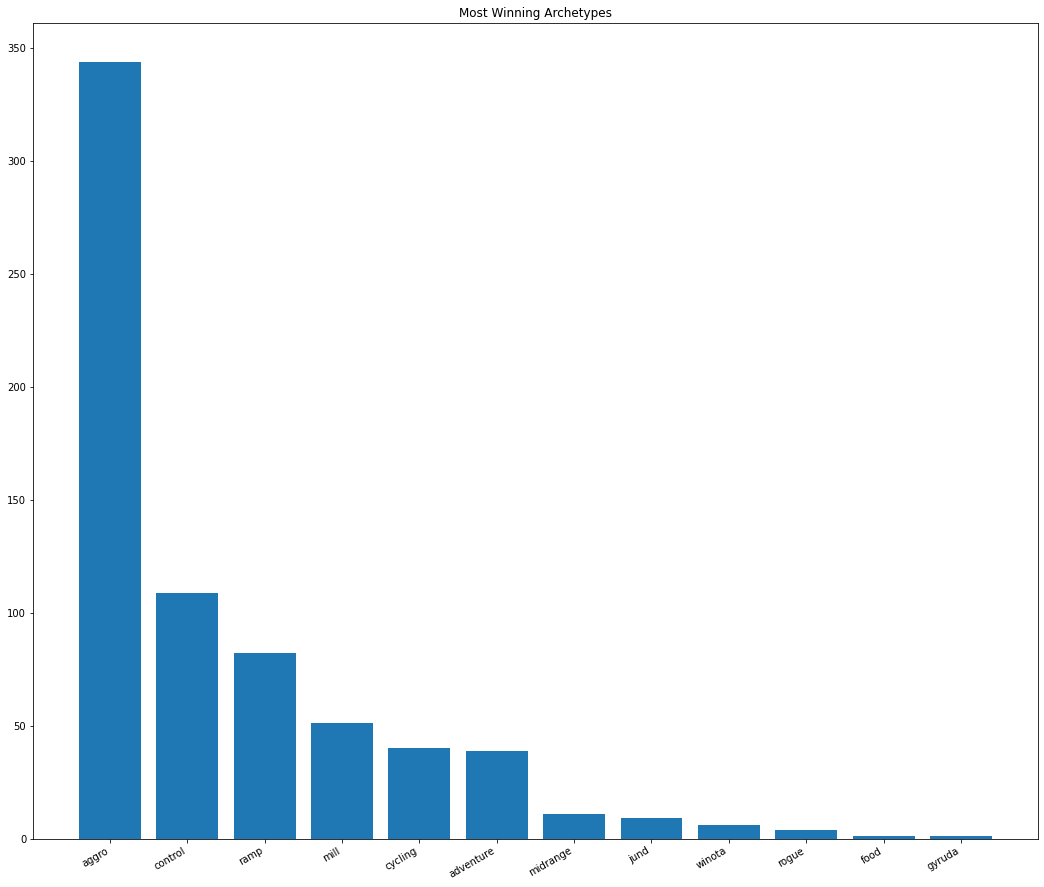

In [14]:
most_winning_archetypes(show=True)

In [15]:
def most_winning_archetypes_last_2_months(df, show=False):
    last_2_months = df[df["event_date"]]

In [16]:
def most_winning_colors(df, show=False):
    grouped_category = df.groupby("category")["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_category, x="category", y="rank")
    plt.title("Most Winning Colors")
    plt.xticks(rotation=30, ha="right")
    if show:
        plt.show()

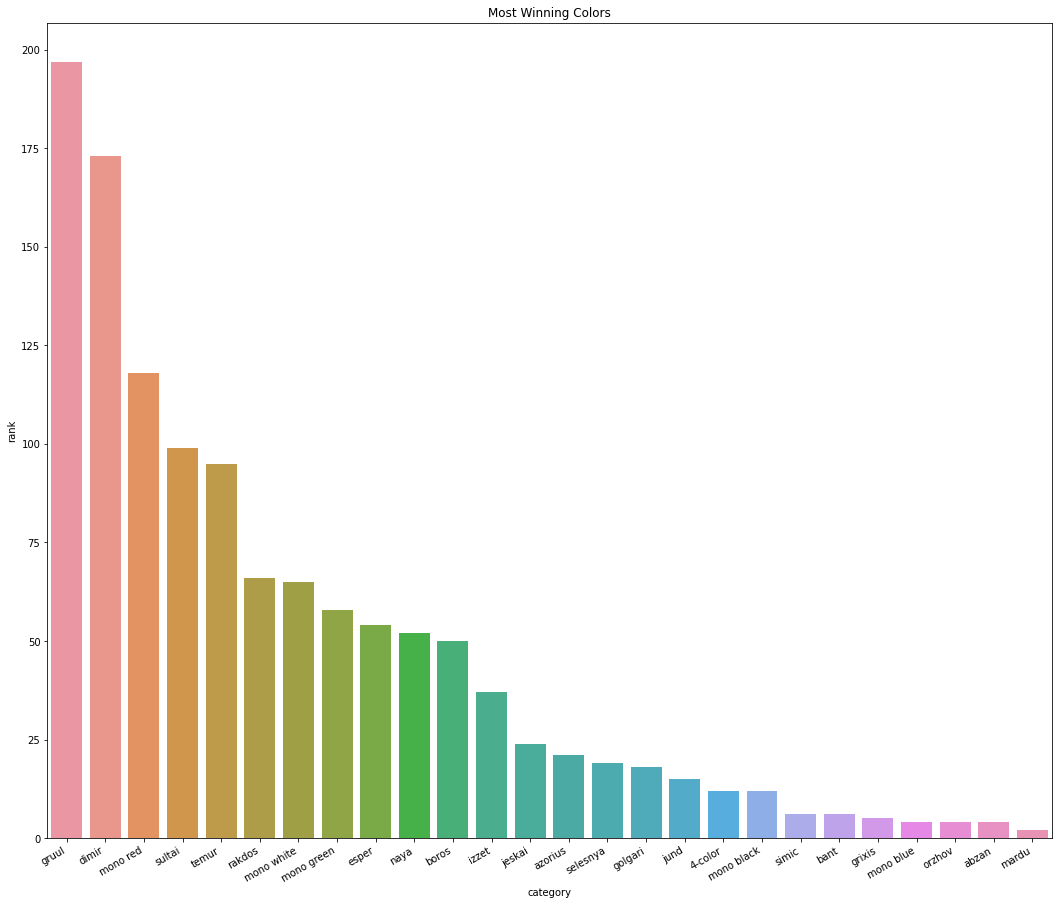

In [17]:
most_winning_colors(first_place_decks)

In [18]:
def most_winning_colors_by_set(df, show=False):
    merged_table = df.merge(event_table[["eventId", "latest_set"]], on="eventId", suffixes=[None, "_event"])
    grouped_table = merged_table.groupby(["category", "latest_set"])["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank", hue="latest_set")
    plt.title("Most Winning Colors During Each Set")
    plt.xlabel("")
    plt.ylabel("Number of Decks")
    plt.xticks(rotation=45, ha="right")
    if show:
        plt.show()

# most_winning_colors_by_set(first_place_decks, show=True)

In [19]:
def what_colors_go_with_archetype(archetypes, colors):
    archetypes = deck_table[deck_table["archetype"].isin(archetypes)]["archetype"]
    colors = deck_table[deck_table["category"].isin(colors)]["category"]
    frequencies = pd.crosstab(archetypes, colors)
    chi2, pval, _, expected = chi2_contingency(frequencies)
    return chi2, pval, frequencies, expected

# what_colors_go_with_archetype(["aggro"], ["mono green", "gruul"])

In [20]:
def colors_and_archetypes(df, archetype, show=False):
    df_archetype = df[df["archetype"] == archetype].copy()
    grouped_table = (
        df_archetype
        .groupby("category")["rank"]
        .count()
        .reset_index()
        .sort_values(by="rank", ascending=False)
    )
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank")
    plt.title(f"Categories in the Most Winning {archetype.title()} Decks")
    plt.xlabel("")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Number of Decks")
    if show:
        plt.show()

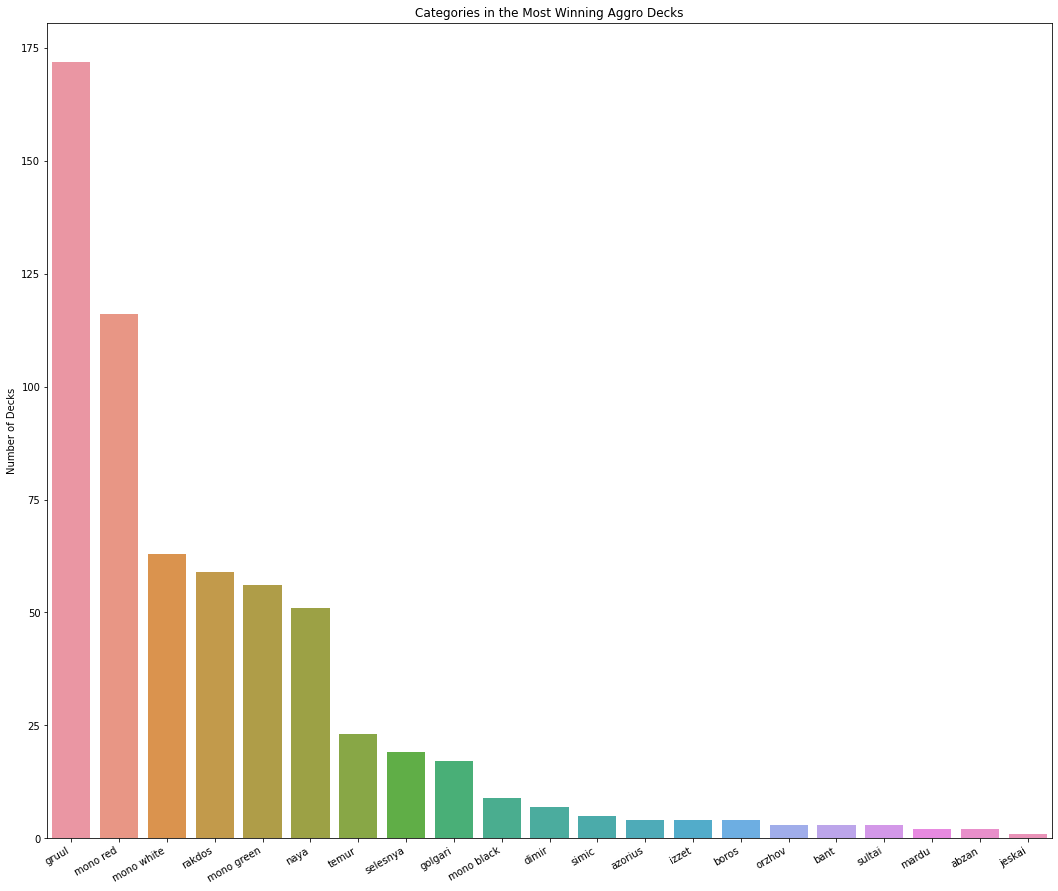

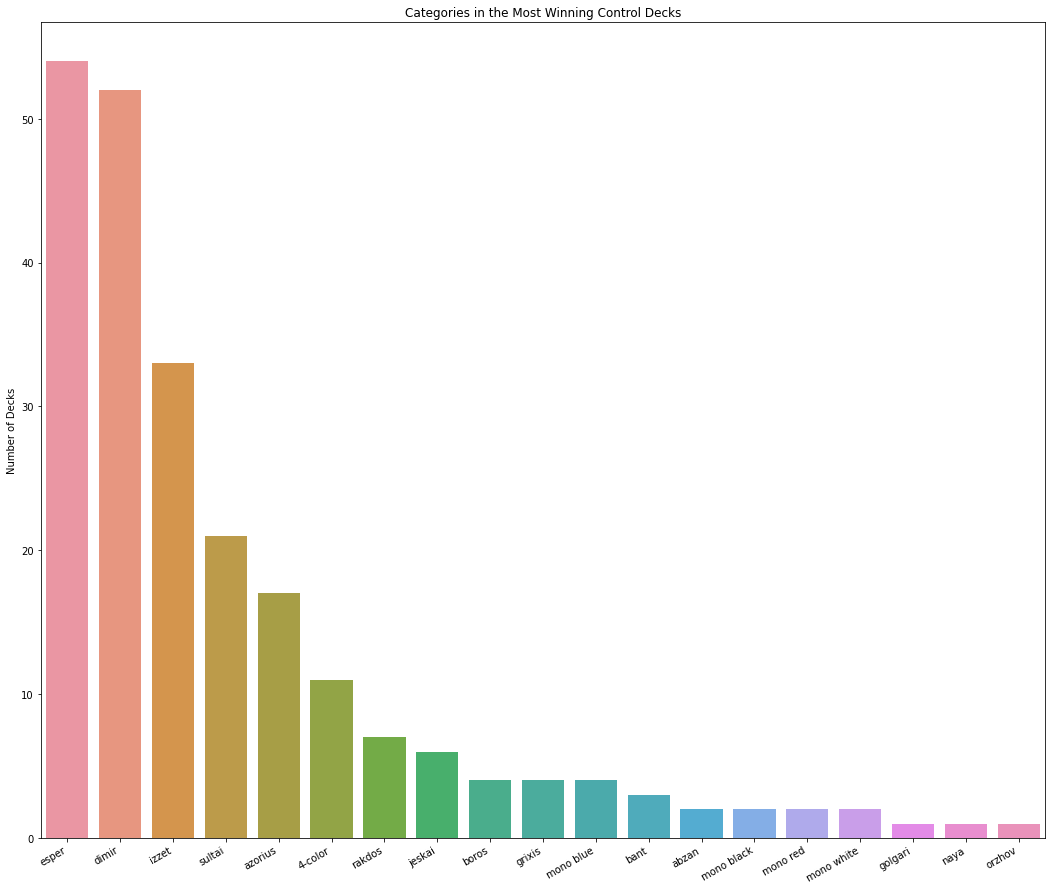

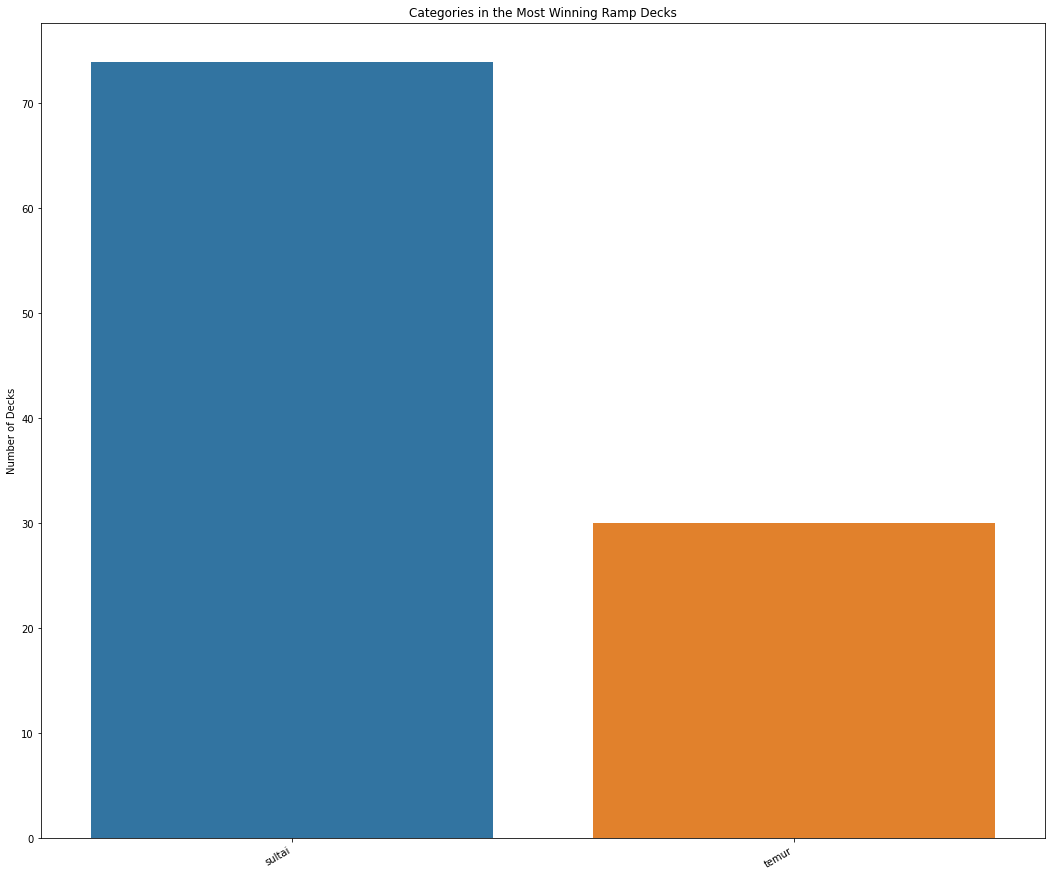

In [21]:
def topn_colors_archetypes(df, n=10, show=False, pdf=None):
    topn_archetypes = df["archetype"].value_counts().index[:n].tolist()
    for archetype in topn_archetypes:
        colors_and_archetypes(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_colors_archetypes(first_place_decks, show=True, n=3)

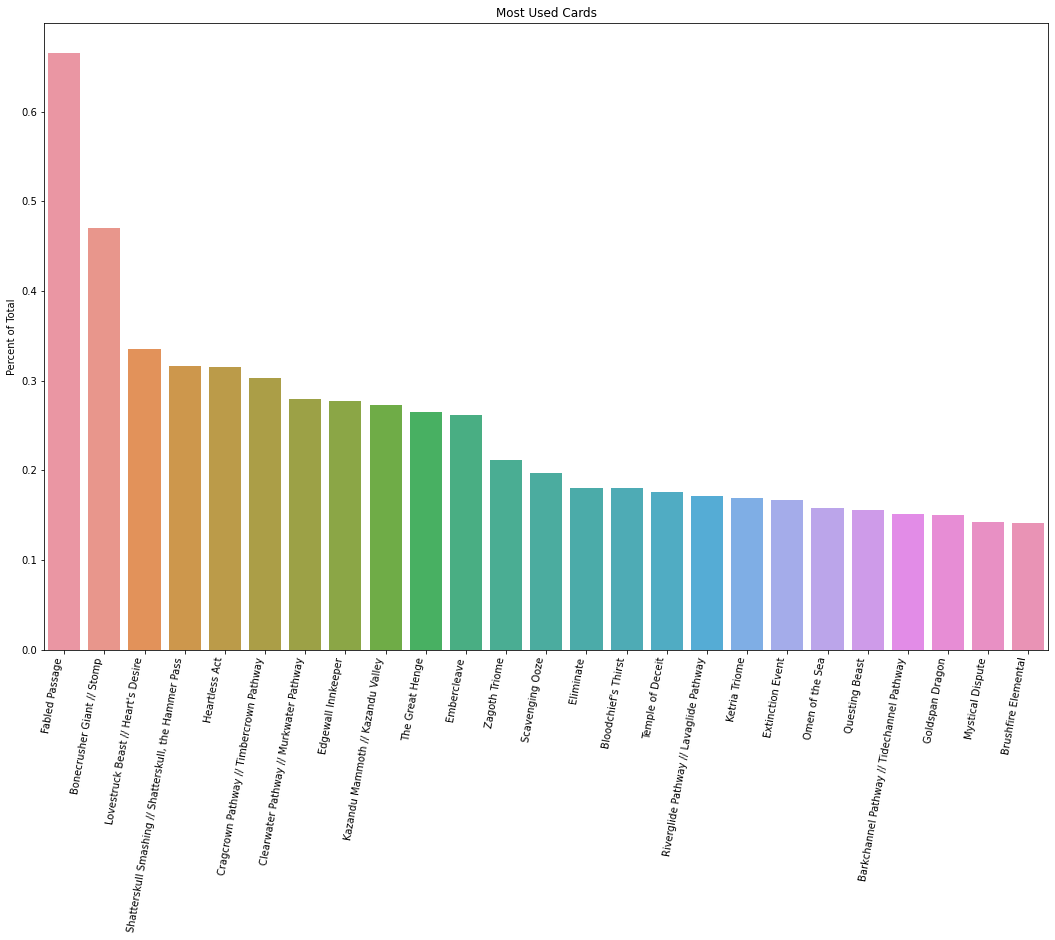

In [22]:
def most_used_cards_graphics(df, show=False):
    this_full_table = df.copy()
    grouped_table = (
        this_full_table
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(this_full_table["deckId"].nunique())
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table.iloc[:25], x="name", y="pct_total")
    plt.title("Most Used Cards")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80, ha="right")
    plt.xlabel("")
    plt.ylabel("Percent of Total")
    if show:
        plt.show()
    
most_used_cards_graphics(main_decks, show=True)

In [23]:
def most_used_cards_in_archetype(df, archetype, show=False):
    this_df = df[df["archetype"] == archetype].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:30], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80, horizontalalignment="right")
    plt.title(f"Most Used Cards in {archetype.title()} Decks")
    plt.ylabel("Percent of All Cards")
    plt.xlabel("")
    if show:
        plt.show()

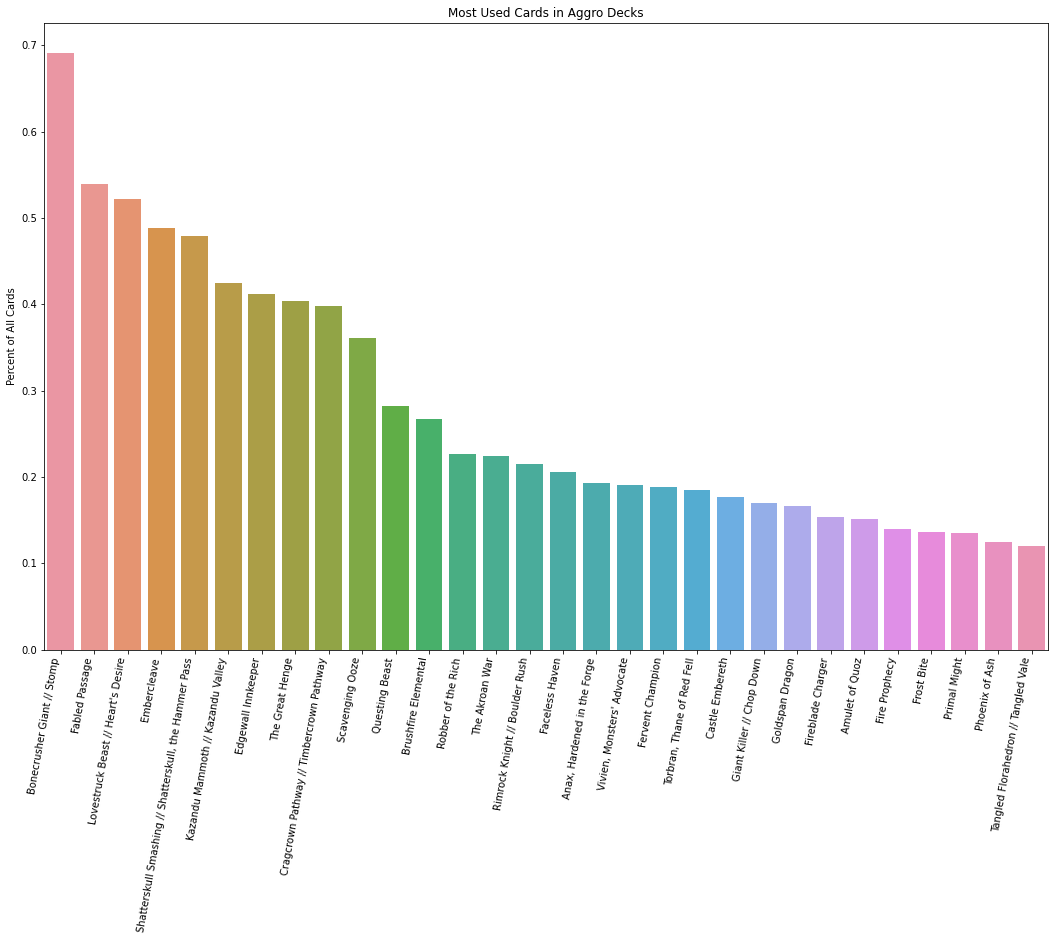

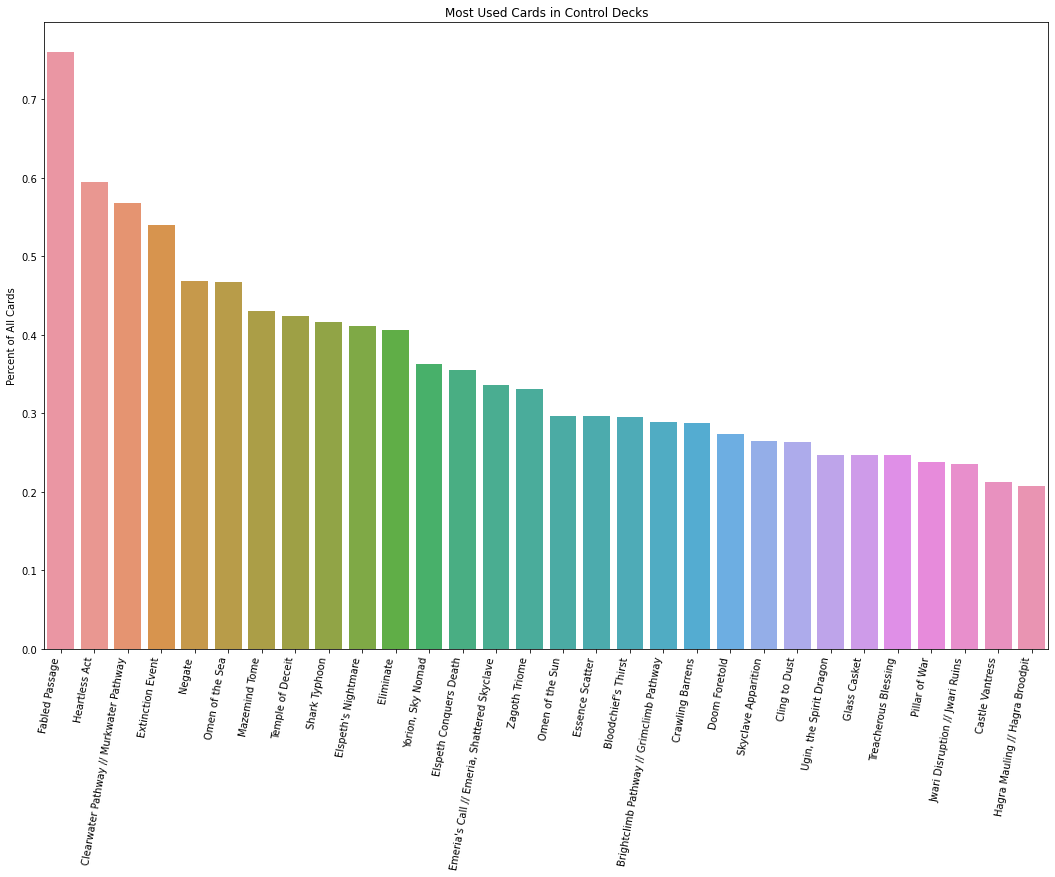

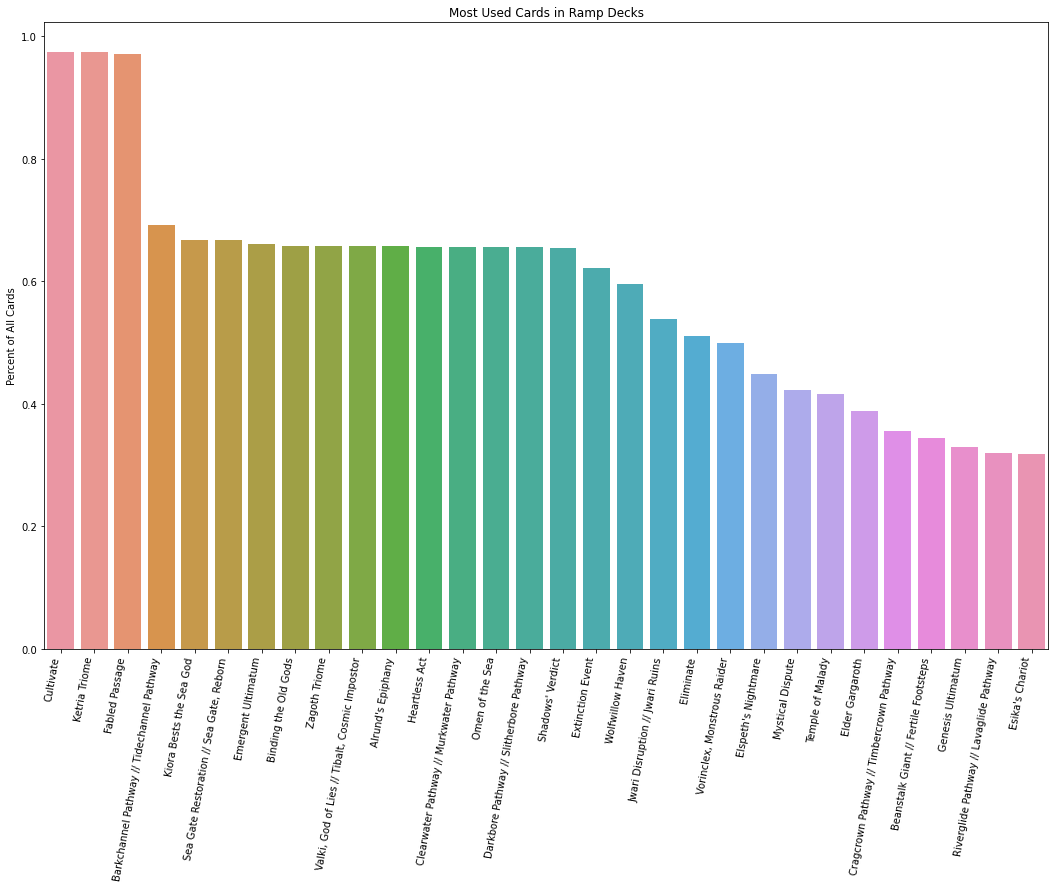

In [24]:
def topn_archetypes(df, n=10, show=False, pdf=None):
    topn_archetypes = deck_table["archetype"].value_counts().index[:n]
    for archetype in topn_archetypes:
        most_used_cards_in_archetype(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_archetypes(main_decks, n=3, show=True)

In [25]:
def most_used_cards_in_category(df, category, show=False):
    this_df = df[df["category"] == category].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:25], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"The Top Cards for {category.title()} Decks")
    plt.ylabel("Percent of Total Decks")
    plt.xlabel("")
    plt.xticks(rotation=80)
    if show:
        plt.show()

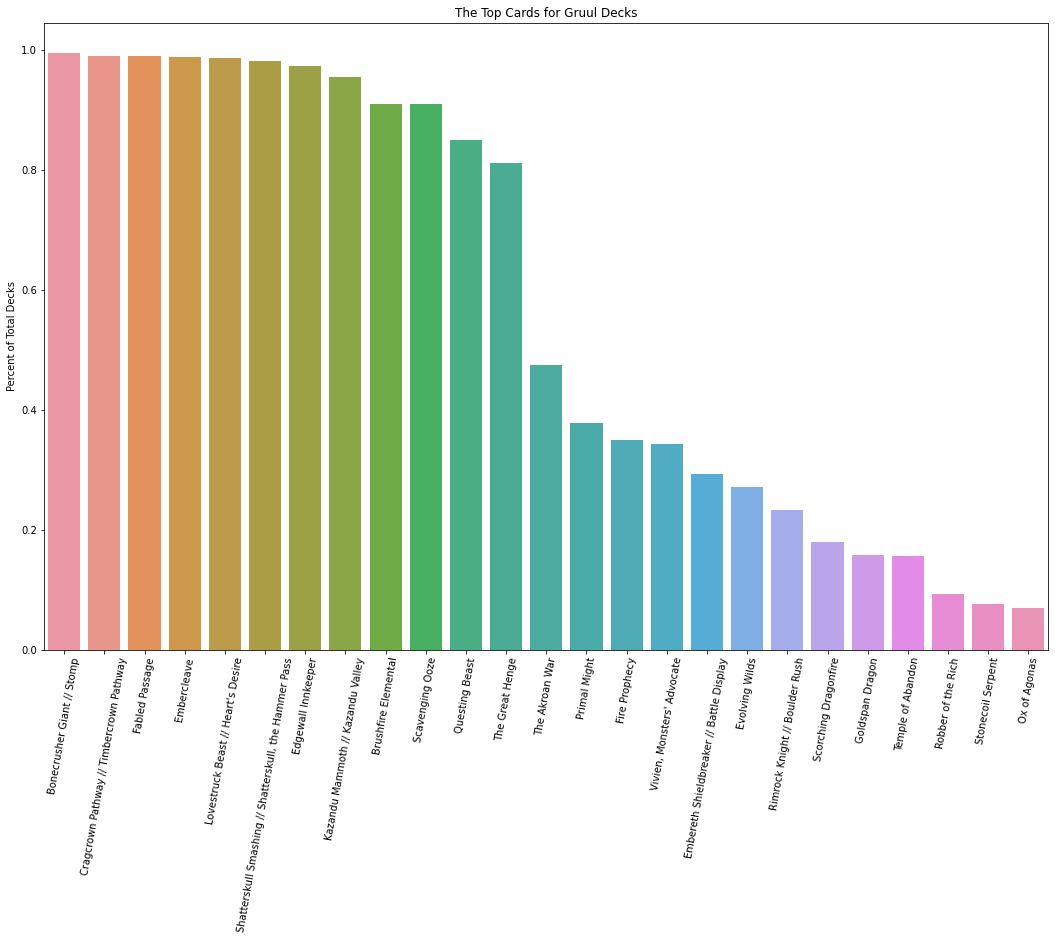

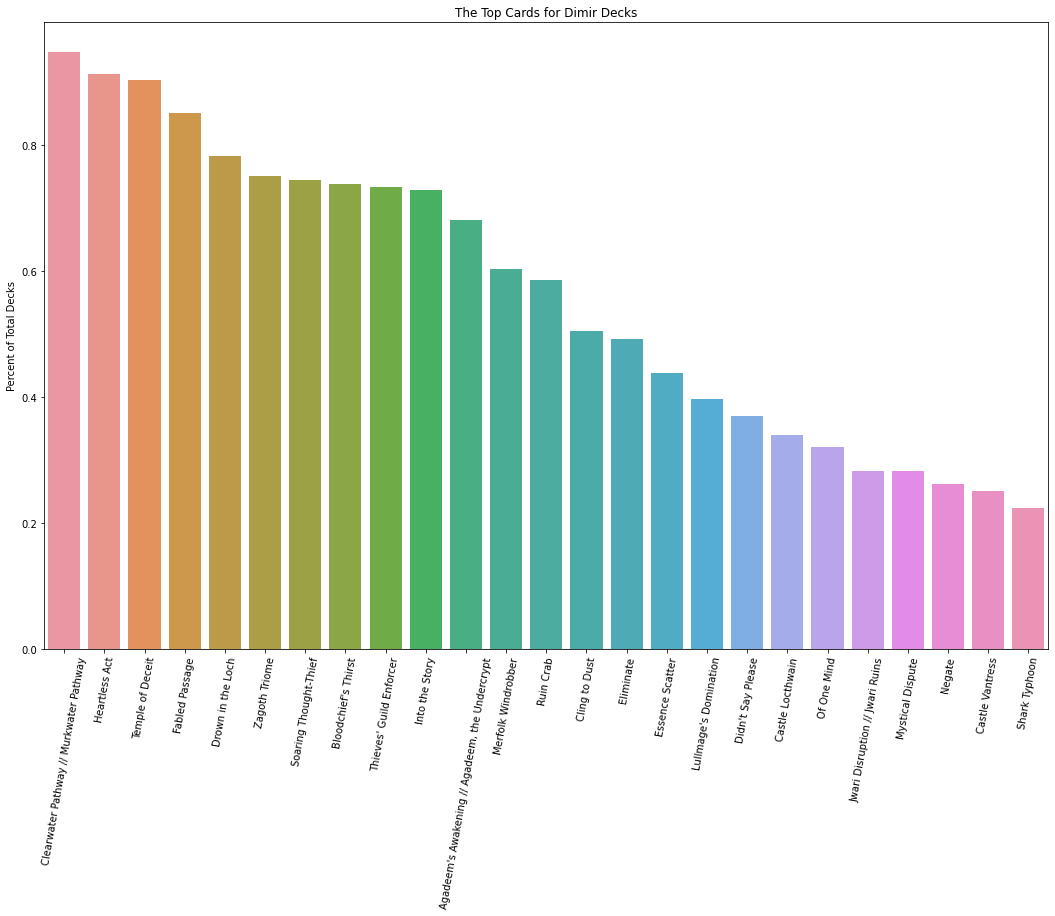

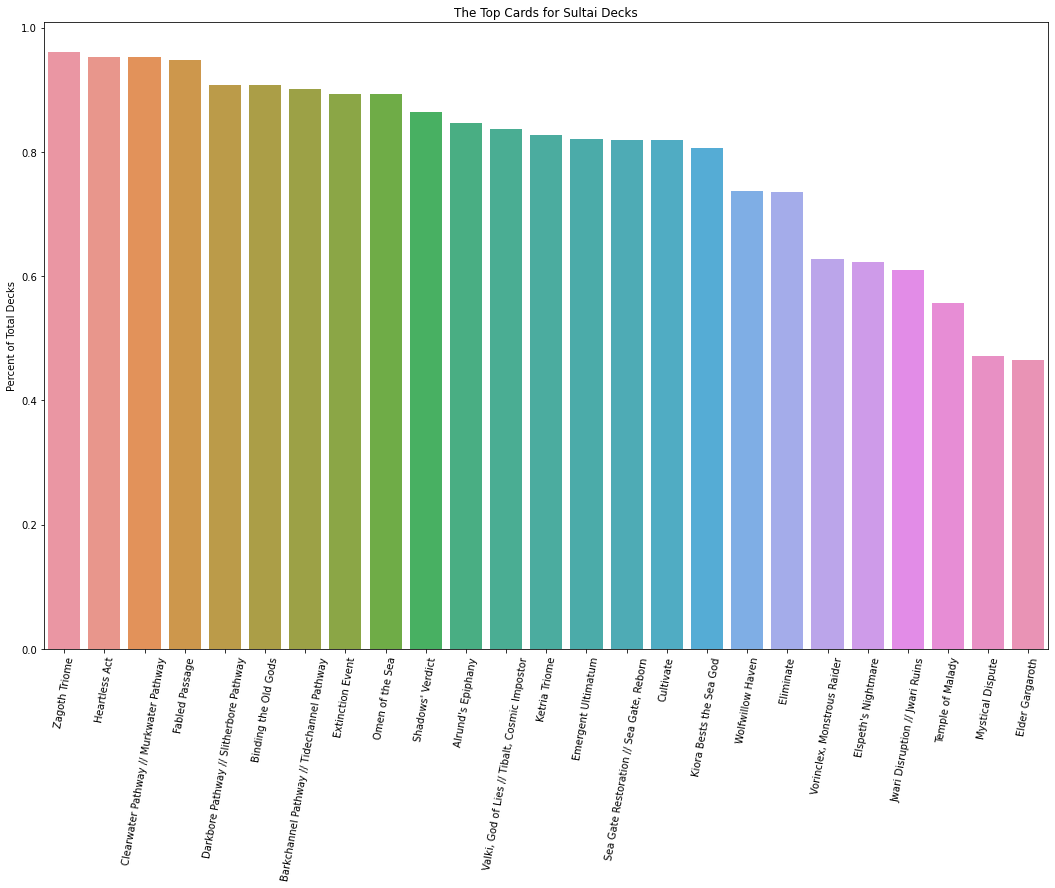

In [26]:
def topn_categories(df, n=10, show=False, pdf=None):
    topn_categories = deck_table["category"].value_counts().index[:n]
    for category in topn_categories:
        most_used_cards_in_category(df, category, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_categories(main_decks, n=3, show=True)

In [27]:
def cards_by_set(df, unique_cards=False, show=False):
    this_df = df[df["deckId"].isin(first_place_decks["deckId"])].copy()
    title = "Cards"
    if unique_cards:
        this_df.drop_duplicates(subset="name", inplace=True)
        title="Unique Cards"
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    plt.figure(figsize=(18, 15))
    sns.countplot(x=this_df["set"], order=this_df["set"].value_counts().index)
    plt.title(f"{title} Used Per Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()
    

In [28]:
first_place_decks

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category
0,1,1,3,?e=27938&d=421597&f=ST,Gruul Aggro,1,aggro,gruul
2,3,2,5,?e=27939&d=421599&f=ST,Red Deck Wins,1,aggro,mono red
3,4,3,6,?e=27940&d=421600&f=ST,Rakdos Aggro,1,aggro,rakdos
4,5,4,7,?e=27925&d=421512&f=ST,Gruul Aggro,1,aggro,gruul
12,13,5,15,?e=27918&d=421478&f=ST,Rakdos Control,1,control,rakdos
...,...,...,...,...,...,...,...,...
5209,5210,975,1036,?e=30666&d=439075&f=ST,Sultai Yorion Ultimatum,1,ramp,sultai
5210,5211,975,115,?e=30666&d=439078&f=ST,Sultai Yorion Ultimatum,1,ramp,sultai
5211,5212,975,2022,?e=30666&d=439079&f=ST,Sultai Yorion Ultimatum,1,ramp,sultai
5212,5213,975,118,?e=30666&d=439086&f=ST,Sultai Yorion Ultimatum,1,ramp,sultai


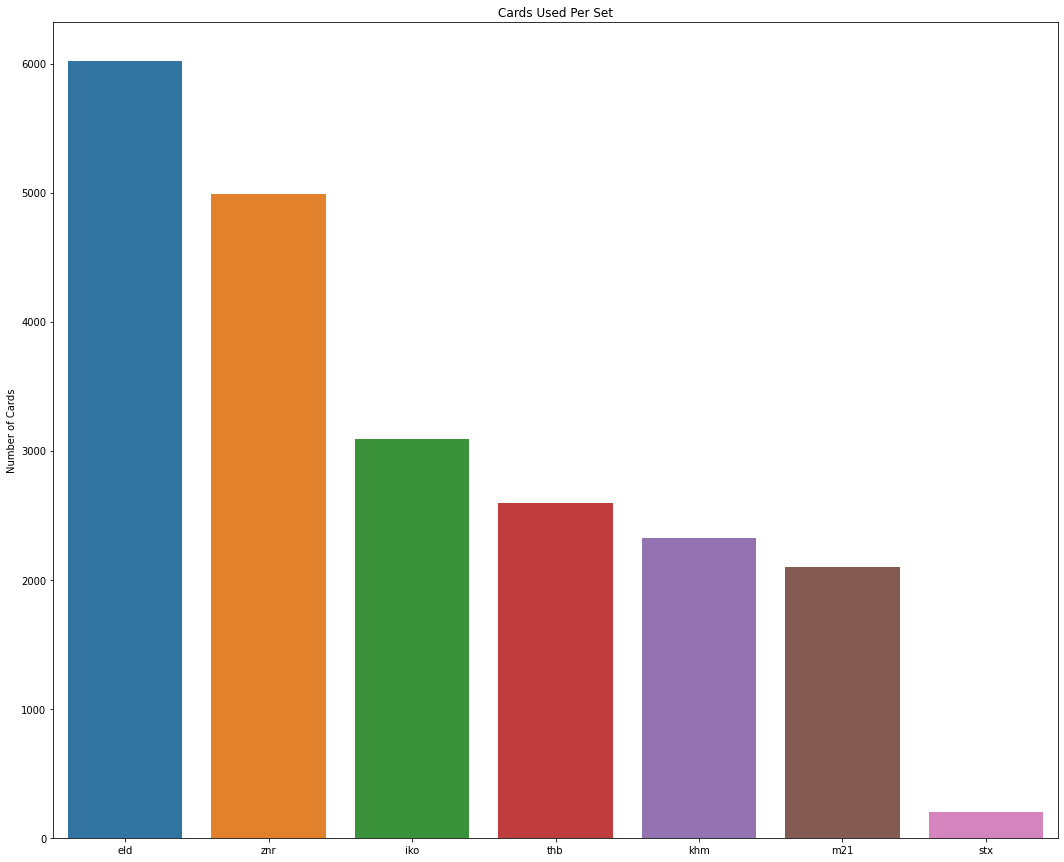

In [29]:
cards_by_set(main_decks,show=True)

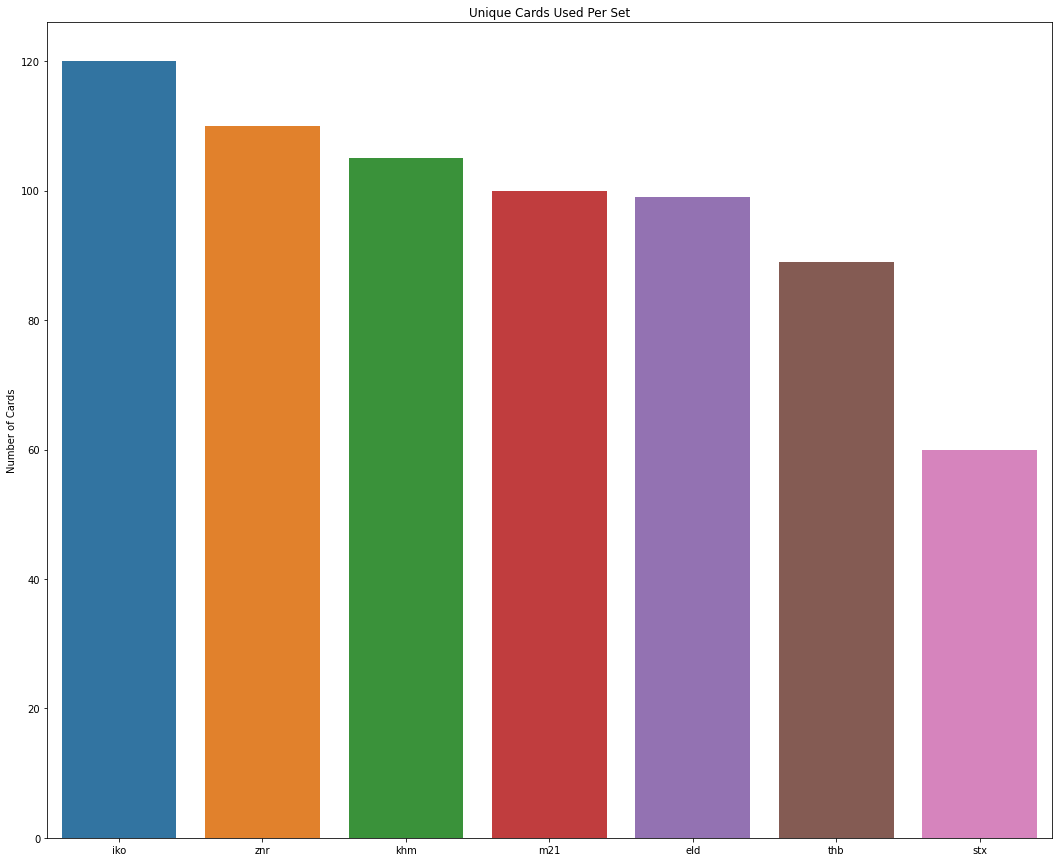

In [30]:
cards_by_set(main_decks,unique_cards=True, show=True)

In [31]:
def sort_by_date(df):
    date_order = []
    for year in ["2020", "2021"]:
        for month in [
            "January", "February", "March", "April", 
            "May", "June", "July", "August", 
            "September", "October", "November", "December"
        ]:
            date_order.append(f"{month} {year}")
    this_df = df.copy()
    
    this_df["month_year"] = pd.Categorical(
        this_df["date"].dt.month_name() + " " + (this_df["date"].dt.year).astype("str"),
        date_order,
        ordered=True
    )
    
    this_df["day"] = this_df["date"].dt.day
    
    return this_df.sort_values(by=["month_year", "day"])

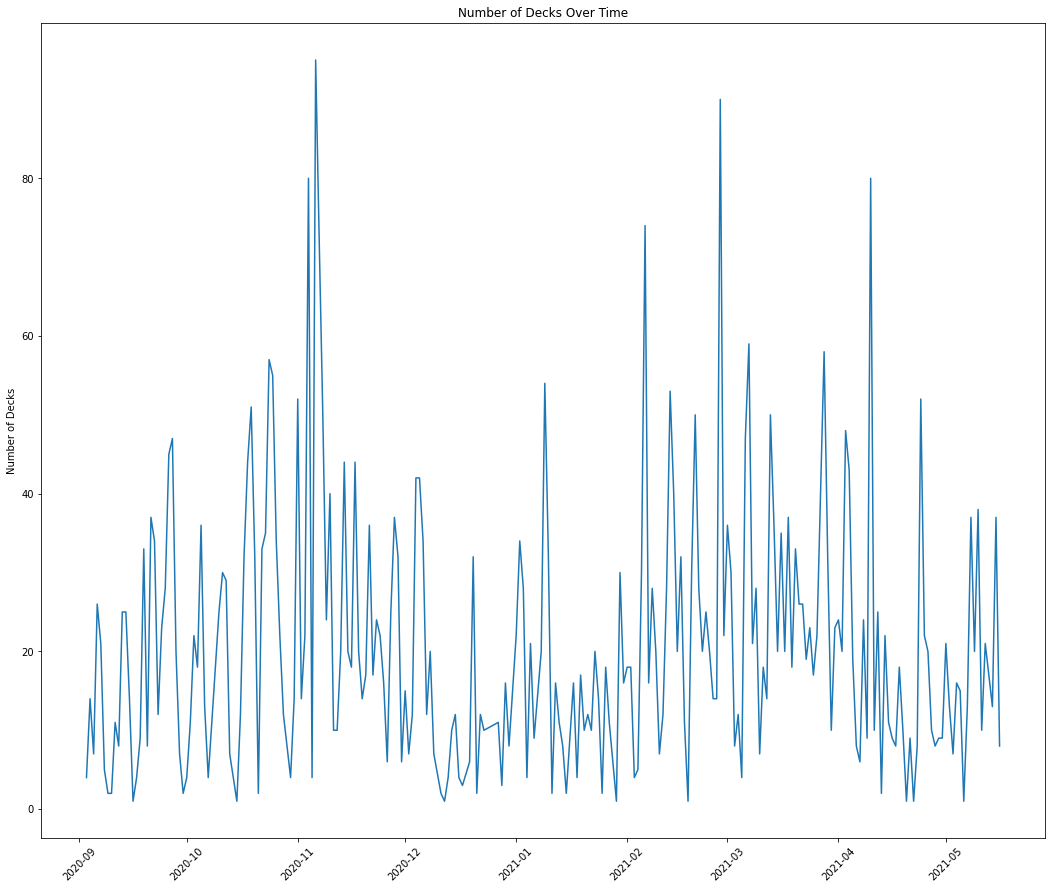

In [32]:
def number_of_decks_over_time(df, show=False):
    this_df = sort_by_date(df)
    grouped_df= (
        this_df
        .groupby(["date"])["deckId"]
        .nunique()
        .reset_index()
    )
    
    plt.figure(figsize=(18, 15))
    plt.plot(grouped_df["date"], grouped_df["deckId"])
    plt.xticks(rotation=45)
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks Over Time")
    if show:
        plt.show()
    
    
number_of_decks_over_time(full_table, show=True)

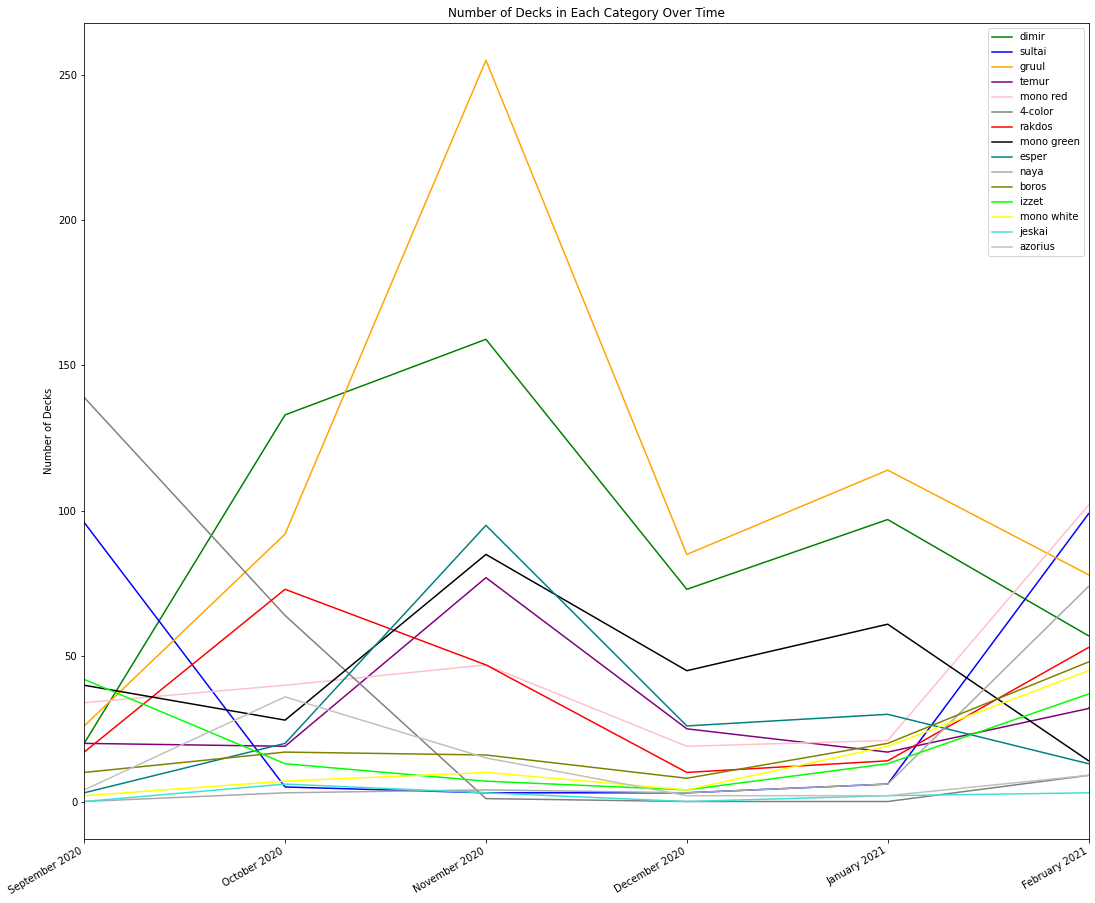

In [33]:
def categories_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "category"])["deckId"]
        .nunique()
        .reset_index()
    )
#     top_categories = this_df[
#         this_df["month_year"] == this_df["month_year"].max()
#     ]["category"].value_counts().index[:15]
    top_categories = this_df["category"].value_counts().index[:15]
    colors = ["green", "blue", "orange", "purple", "pink",
              "grey", "red", "black", "teal", "darkgrey",
              "olive", "lime", "yellow", "turquoise", "silver"
             ]
    plt.figure(figsize=(18, 15))
    for cat, color in zip(top_categories, colors):
        cat_df = grouped_df[grouped_df["category"]==cat]
        plt.plot(cat_df["month_year"], cat_df["deckId"], label=cat, color=color)
    
    plt.xticks(rotation=30, ha="right")
    plt.xlim(["September 2020", "February 2021"])
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks in Each Category Over Time")
    plt.legend()
    if show:
        plt.show()
    
categories_over_time(full_table, show=True)

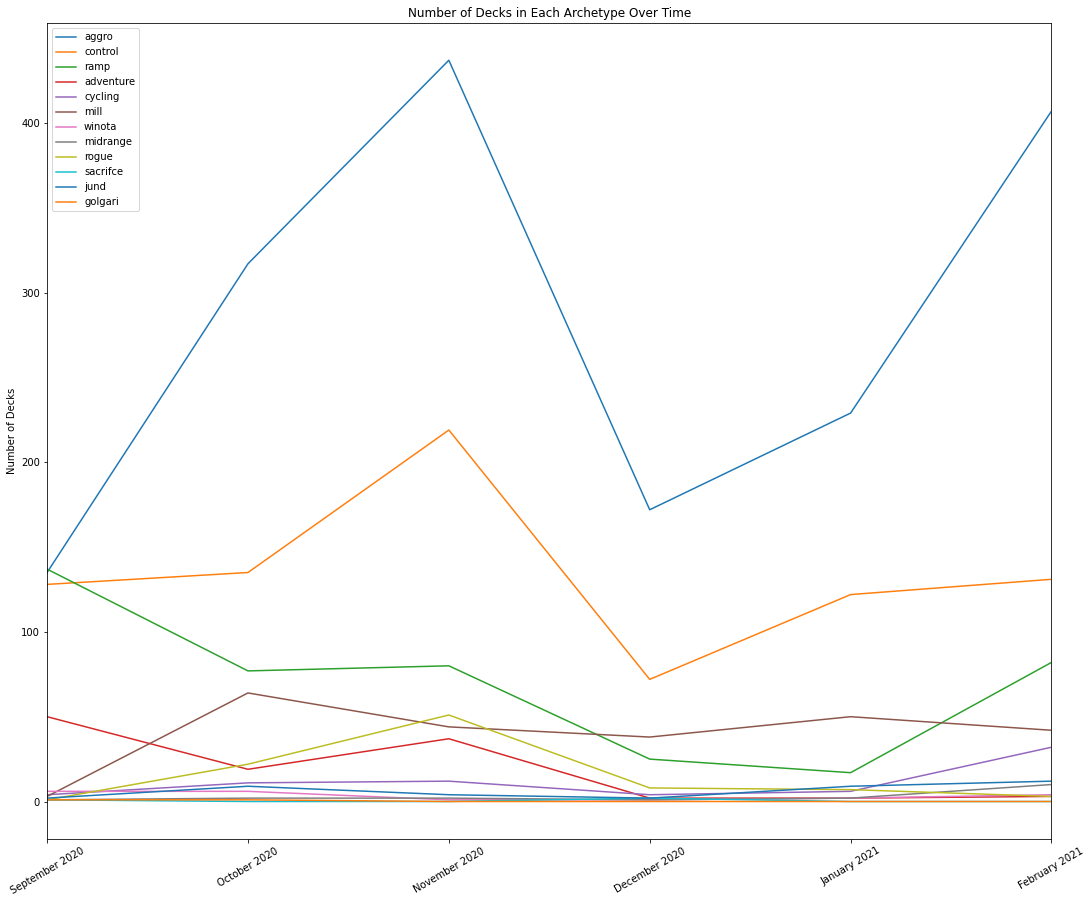

In [34]:
def archetypes_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "archetype"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_archetypes = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["archetype"].value_counts().index[:15]
    
    plt.figure(figsize=(18, 15))
    for archetype in top_archetypes:
        archetype_df = grouped_df[grouped_df["archetype"]==archetype]
        plt.plot(archetype_df["month_year"], archetype_df["deckId"], label=archetype)
    
    plt.title("Number of Decks in Each Archetype Over Time")
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])   
    plt.ylabel("Number of Decks")
    plt.legend()
    if show:
        plt.show()
    
archetypes_over_time(full_table, show=True)

In [35]:
def arena_vs_nonarena(df):
    this_df = df.copy()
    this_df["is_arena"] = df.apply(lambda x: "arena" if "arena" in x["name_event"].lower() else "not_arena", axis=1)
    arena_freq = pd.crosstab(this_df["archetype"], this_df["is_arena"])
    _, pval, _, _ = chi2_contingency(arena_freq)
    return pval
    

In [36]:
masked_table = full_table.copy()

cat_count = masked_table["category"].value_counts()

mask = masked_table["category"].isin(cat_count[cat_count < 2000].index)

masked_table["category"][mask] = "other"

masked_table

<ipython-input-36-443826df187f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_table["category"][mask] = "other"


,eventId,name_event,date,deckId,pilotId,name_deck,firstName,lastName,cardId,name,count,color,slot,archetype,category,latest_set
0,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,261znr,Cragcrown Pathway // Timbercrown Pathway,4,GR,md,aggro,gruul,Zendikar Rising
1,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,244eld,Fabled Passage,4,NaN,md,aggro,gruul,Zendikar Rising
2,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,266eld,Forest,9,G,md,aggro,gruul,Zendikar Rising
3,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,262eld,Mountain,5,R,md,aggro,gruul,Zendikar Rising
4,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,115eld,Bonecrusher Giant // Stomp,4,R,md,aggro,gruul,Zendikar Rising
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142594,975,MPL @ May Strixhaven League Weekend,2021-05-15,5214,117,Weenie White,Ken,Yukuhiro,318znr,Legion Angel,2,W,sb,aggro,mono white,Strixhaven
142595,975,MPL @ May Strixhaven League Weekend,2021-05-15,5214,117,Weenie White,Ken,Yukuhiro,011iko,Drannith Magistrate,2,W,sb,aggro,mono white,Strixhaven
142596,975,MPL @ May Strixhaven League Weekend,2021-05-15,5214,117,Weenie White,Ken,Yukuhiro,012khm,Glorious Protector,2,W,sb,aggro,mono white,Strixhaven
142597,975,MPL @ May Strixhaven League Weekend,2021-05-15,5214,117,Weenie White,Ken,Yukuhiro,023m21,Idol of Endurance,2,W,sb,aggro,mono white,Strixhaven


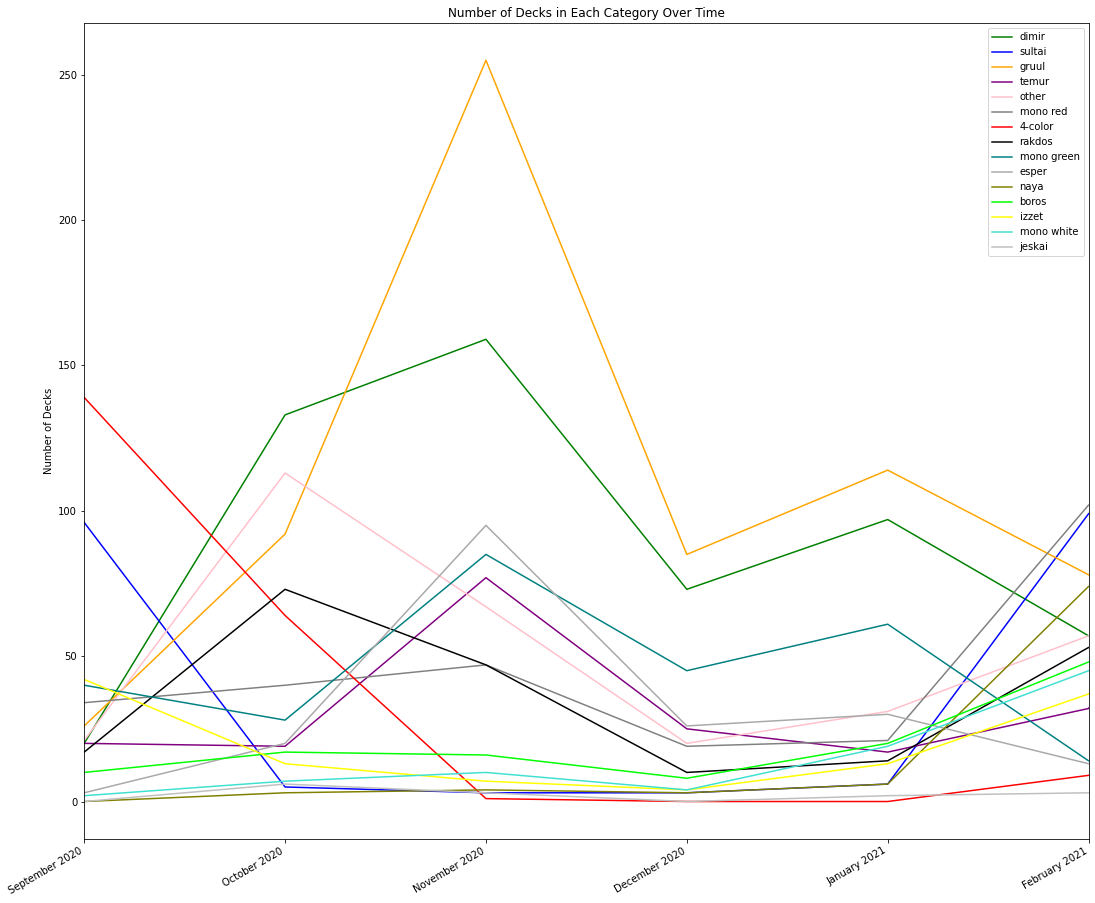

In [37]:
categories_over_time(masked_table)

In [38]:
def color_dominance(df, color, show=False):
    this_df = df.copy().fillna("")
    color_cards = this_df[
        (this_df["color"].str.contains(color))
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=color_cards, x="name", y="count")
    plt.xticks(rotation=80, ha="right")
    plt.subplots_adjust(bottom=0.3)
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    plt.title(f"Most Used {color.title()} Cards")
    if show:
        plt.show()

In [39]:
def plot_color_dominance(df, show=False, pdf=None):
    for color in ["W", "U", "B", "R", "G"]:
        color_dominance(df, color, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

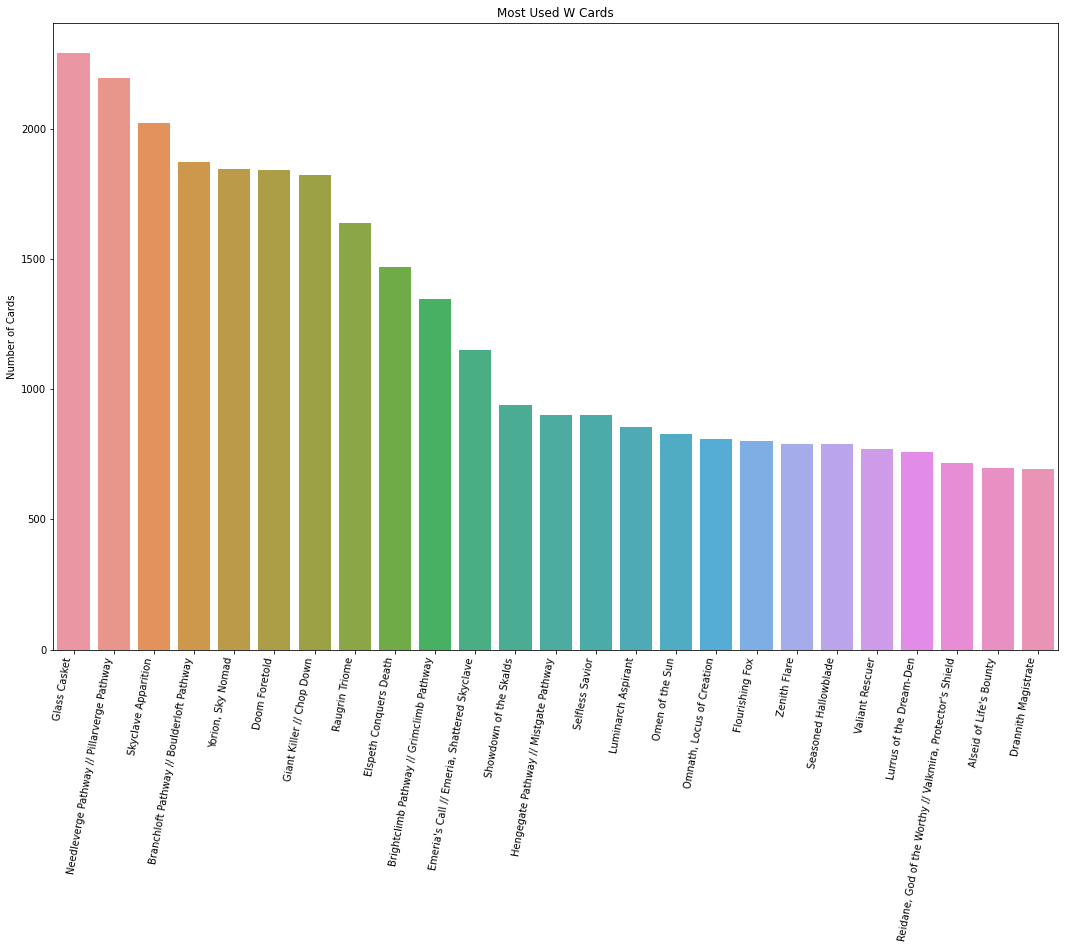

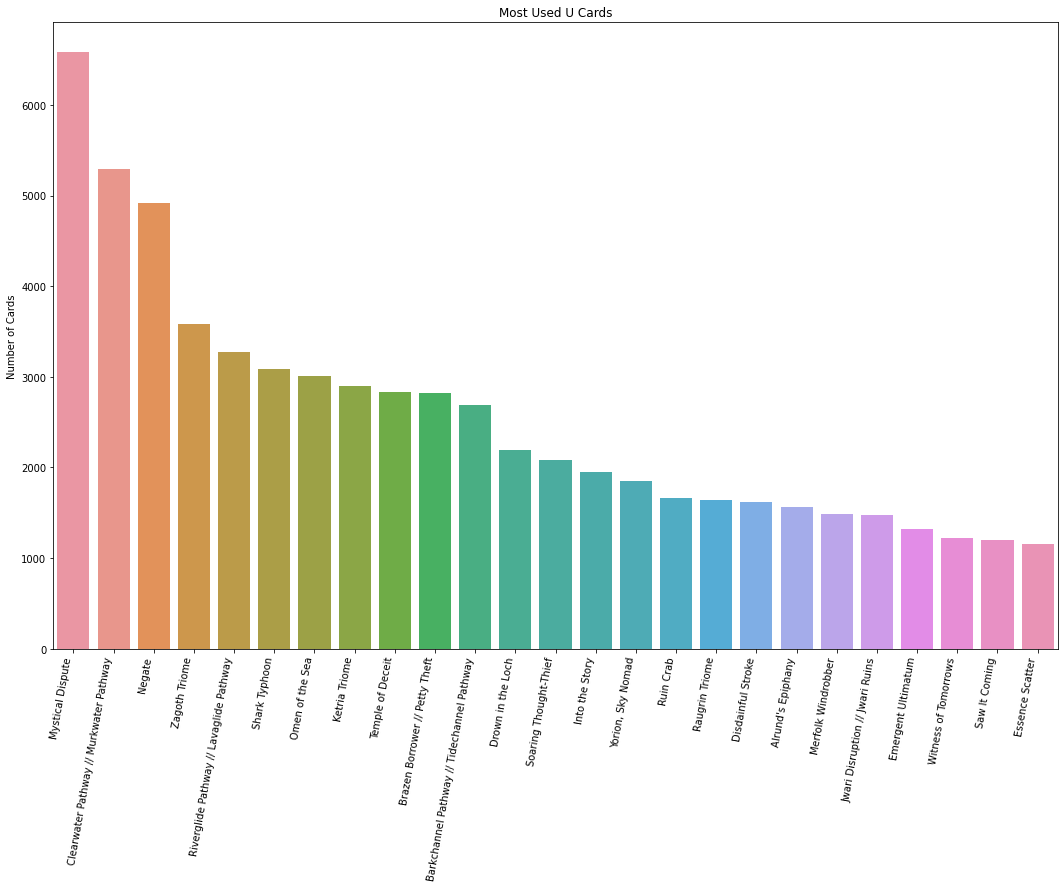

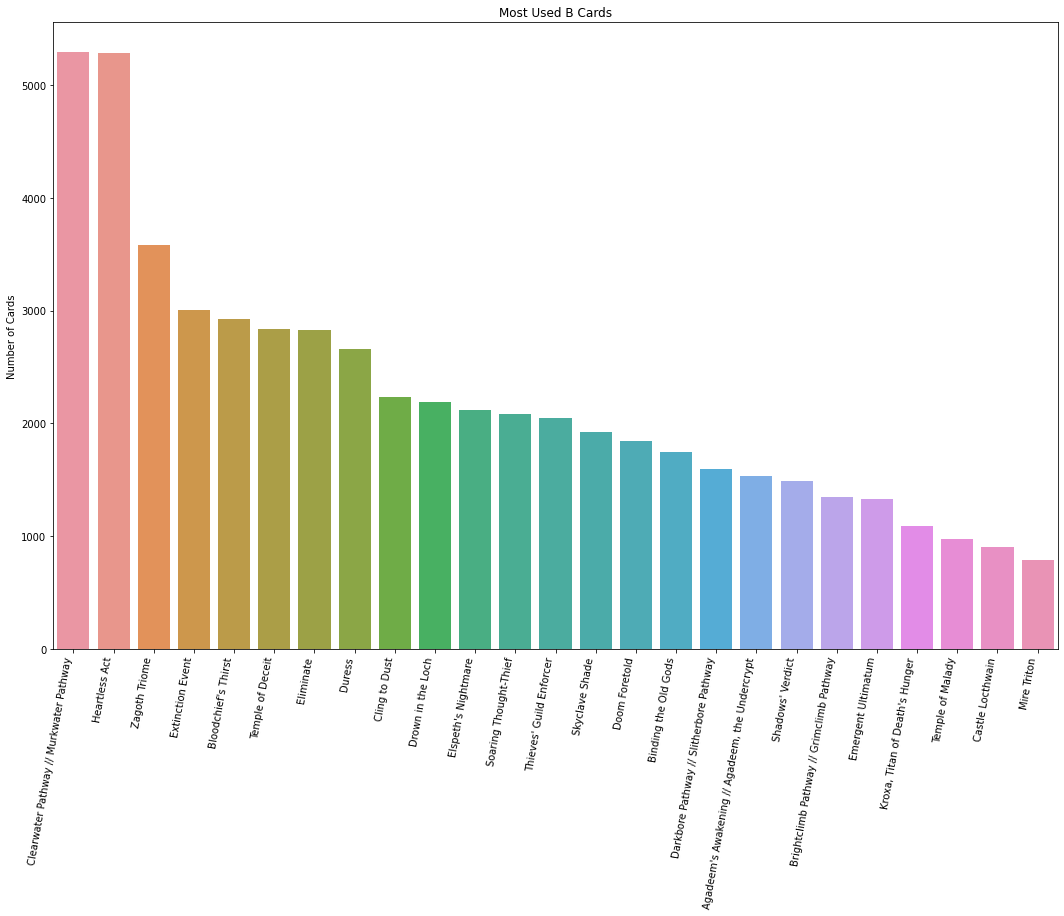

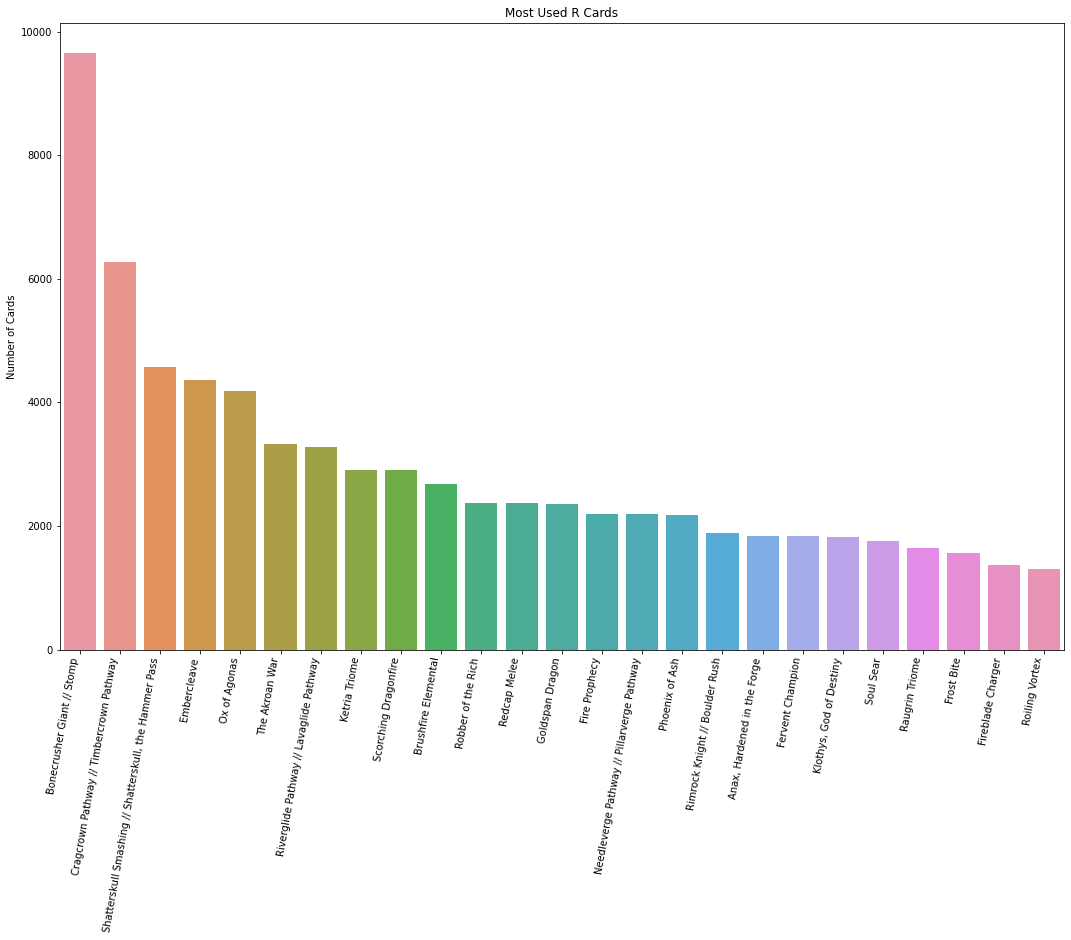

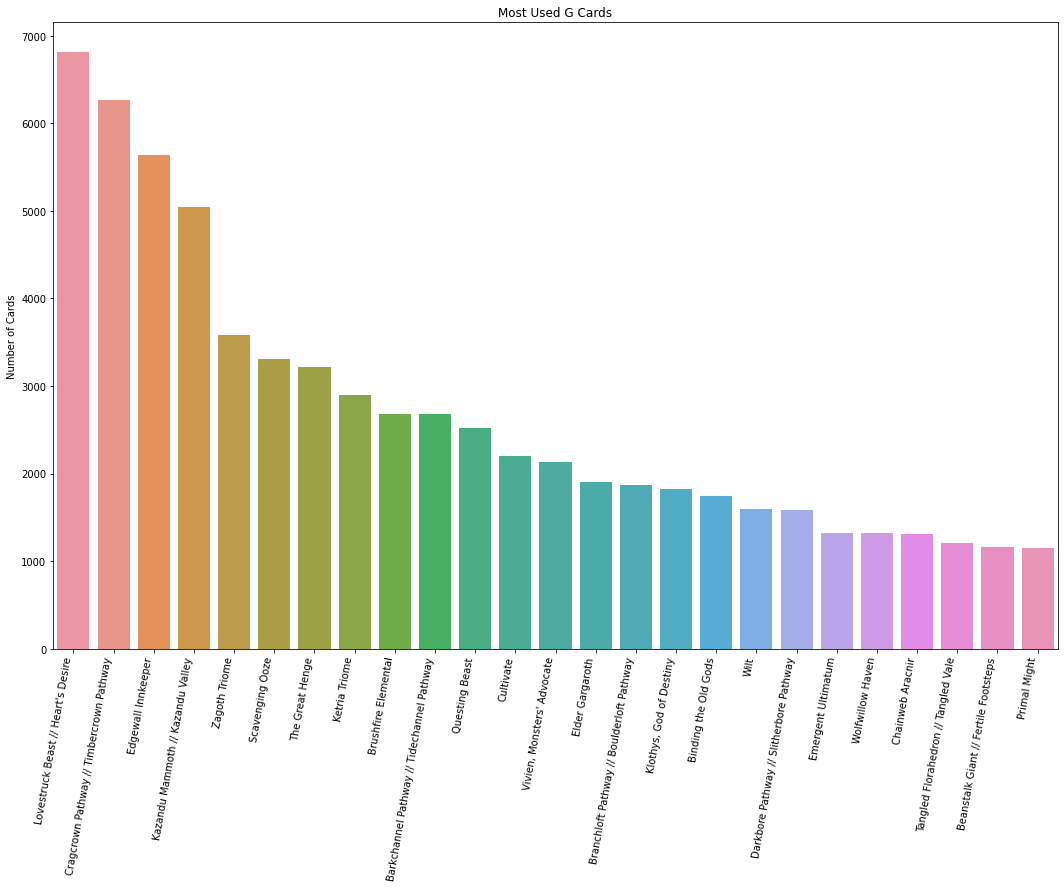

In [40]:
plot_color_dominance(full_table, show=True)

In [41]:
def set_dominance(df, set_code, show=False):
    this_df = df.copy().fillna("")
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    set_df = this_df[
        (this_df["set"] == set_code)
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
        & (~this_df["name"].str.contains("Snow-Covered"))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=set_df, x="name", y="count")
    plt.xticks(rotation=80, ha="right")
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"Most Used Cards from {set_code.title()} Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()

In [42]:
def plot_set_dominance(df, show=False, pdf=None):
    for set_code in ["eld", "thb", "iko", "znr", "m21", "khm"]:
        set_dominance(df, set_code, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

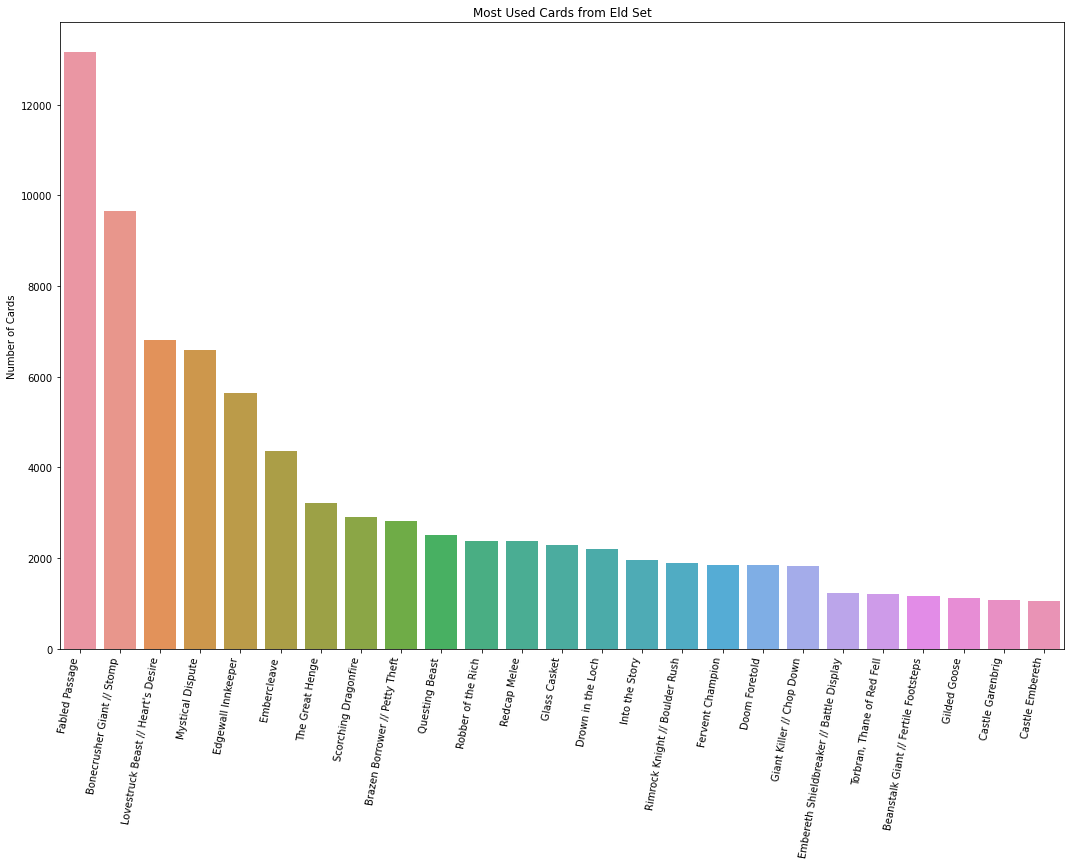

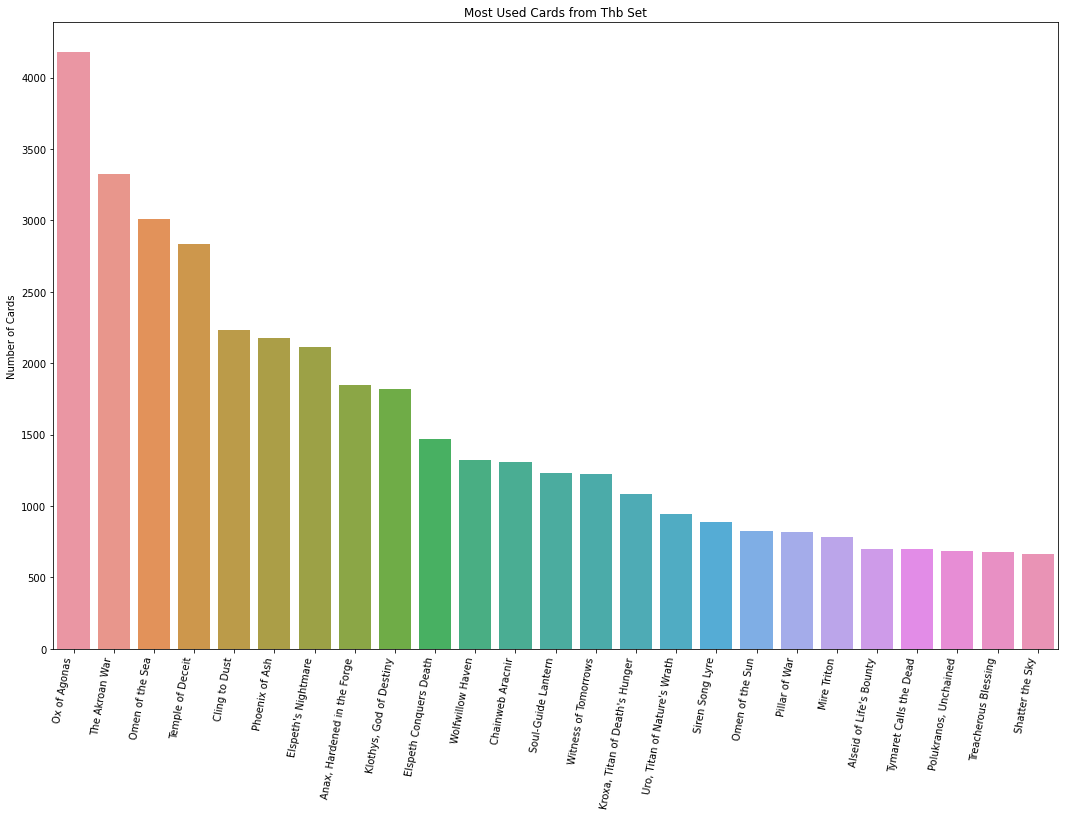

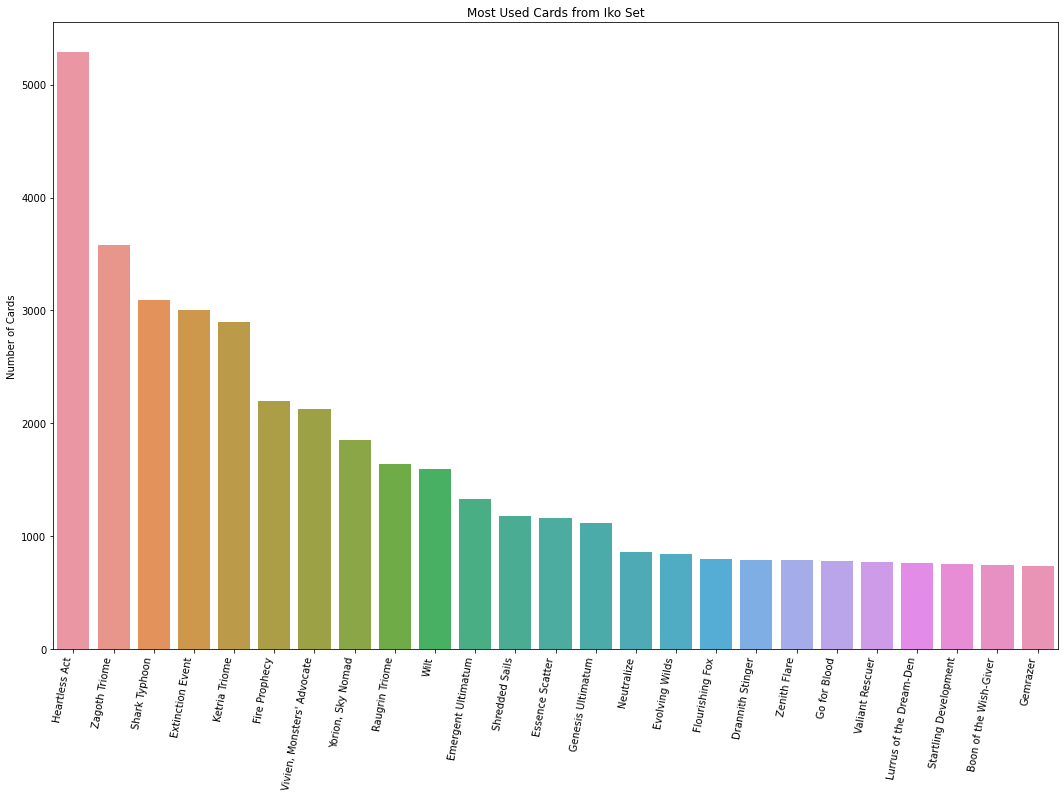

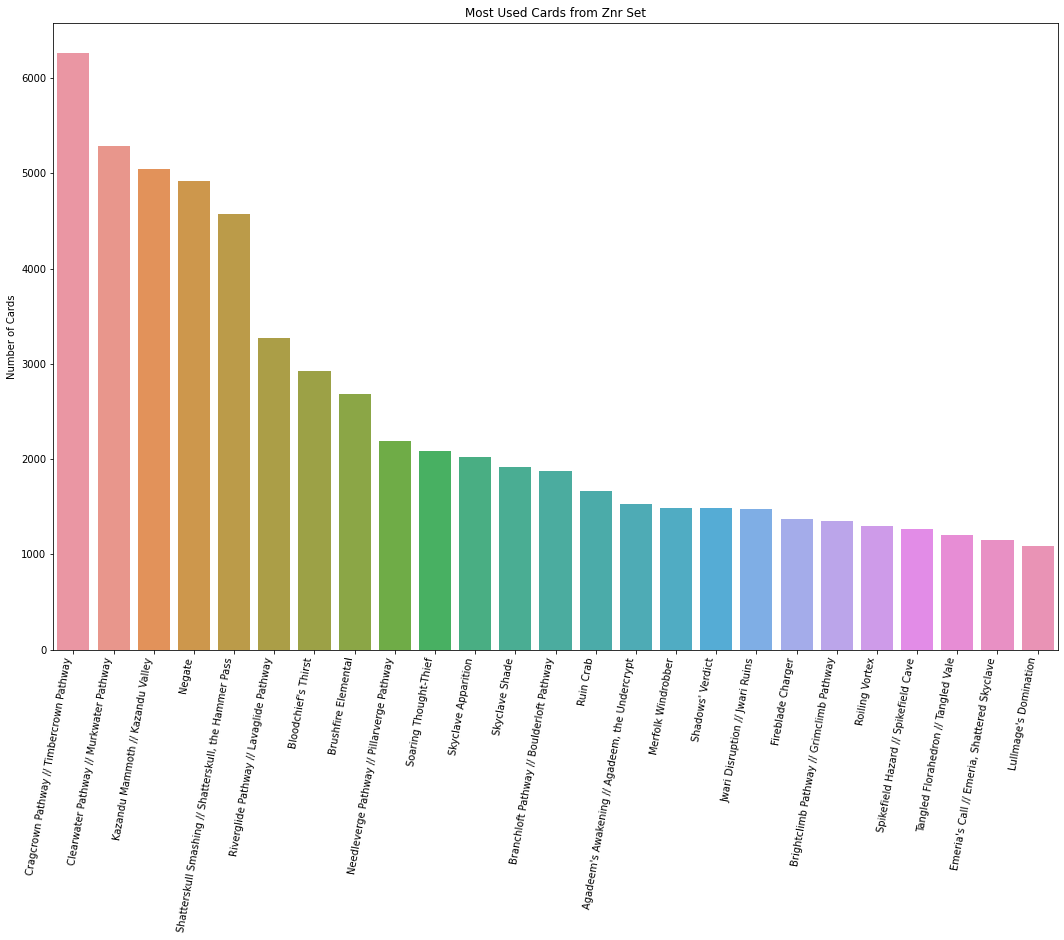

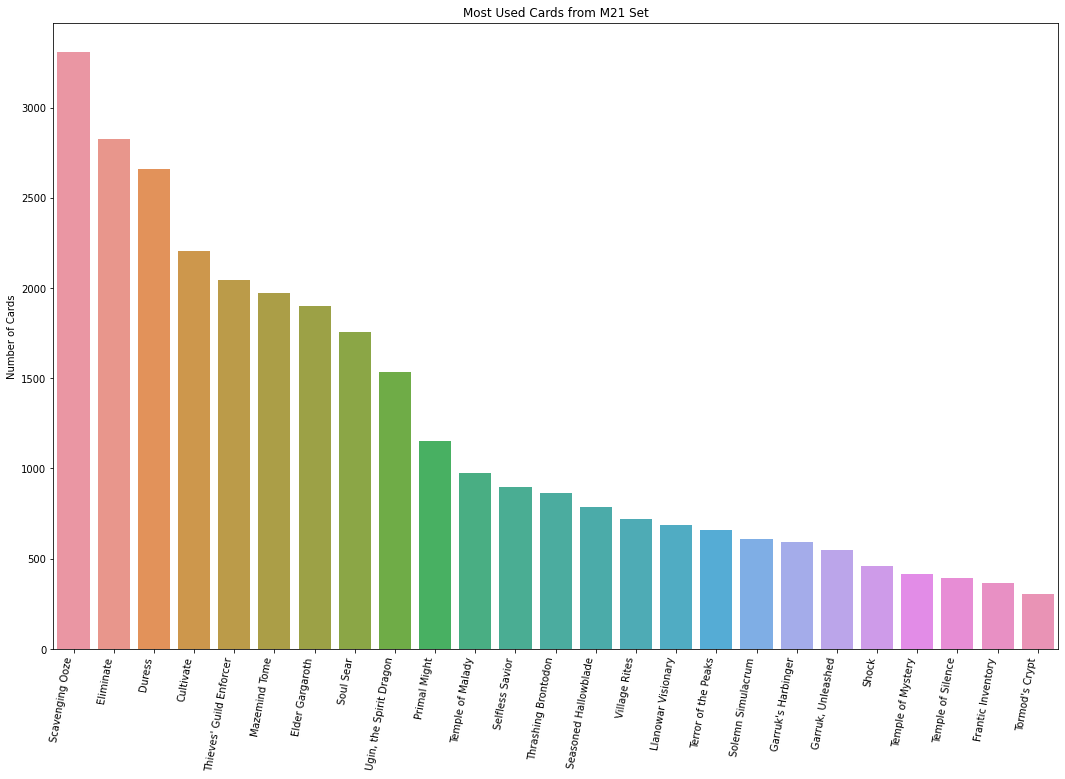

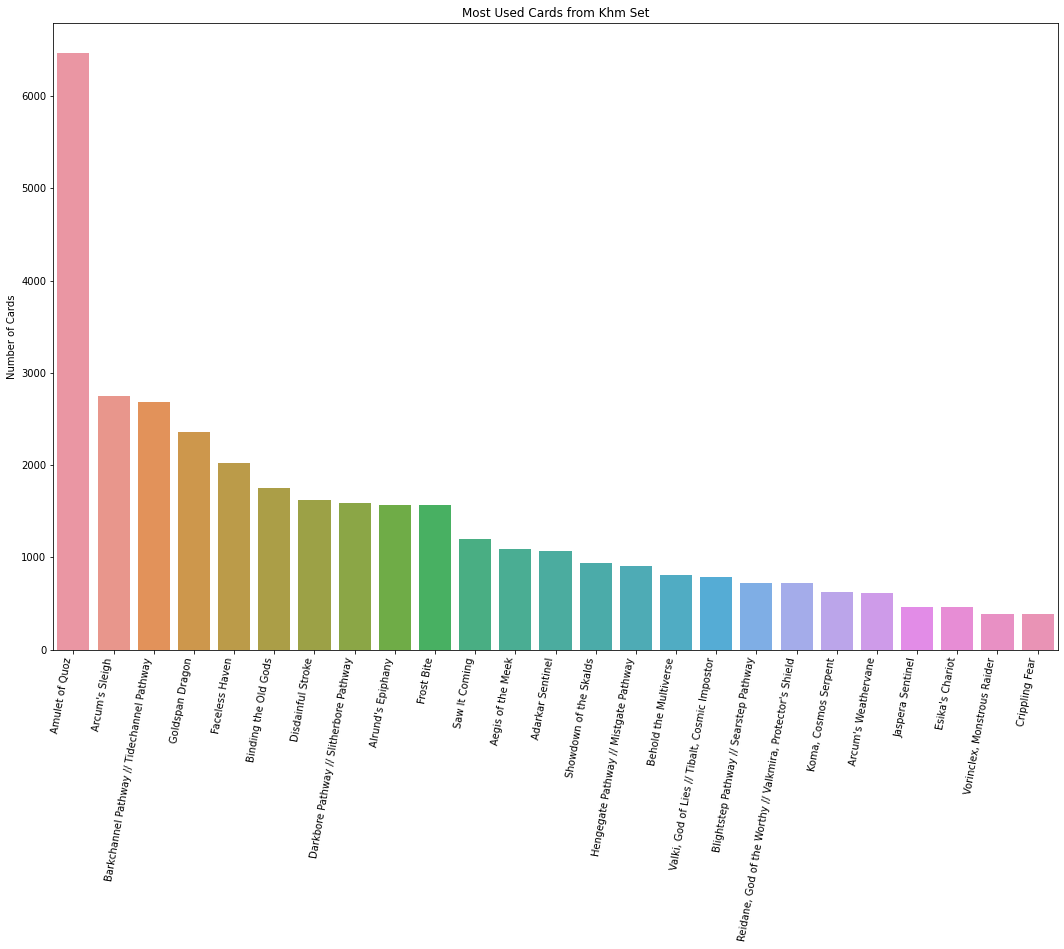

In [43]:
plot_set_dominance(full_table, show=True)

In [44]:
def oracle_text_analysis(df=most_used_cards):
    this_df = (
        df[["name"]]
        .merge(card_table[["name", "oracle_text"]], on="name", how="left")
        .drop_duplicates()
        .copy()
    )
    return this_df[
        (~this_df["name"].str.contains("Triome|Pathway|Fabled Passage", regex=True))
    ]

In [45]:
oracle_texts = oracle_text_analysis()

In [46]:
def get_part_of_speech(word):
    
    # wordnet.synsets(word) returns a list of all the available synonyms in ntlk corpus
    probable_part_of_speech = wordnet.synsets(word)

    pos_counts = Counter()
    
    # Gets the number of times each word is labeled as "n", "v", "a", or "r" in synsets
    pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
    
    # The most common item in Counter is the one with the most synsets of a particular pos
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

In [47]:
def process_text(text):
    cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', "", text)
    tokenized = word_tokenize(cleaned)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    return [word.lower() for word in lemmatized if word not in stop_words]

In [48]:
def get_tf_idf_scores(corpus):
    processed_corpus = [process_text(text) for text in corpus]
    vectorizer = TfidfVectorizer(norm=None, lowercase=None)
    tfidf_scores = vectorizer.fit_transform(processed_corpus)
    return tfidf_scores

In [49]:
texts = oracle_texts["oracle_text"].fillna("").tolist()
# processed_texts = [process_text(text) for text in texts]

In [50]:
test_vectorizer = TfidfVectorizer(norm=None, stop_words=stopwords.words("english"))
tfidf_scores = test_vectorizer.fit_transform(texts)

In [51]:
# test_vectorizer.get_feature_names()

# test_vectorizer.vocabulary_

In [52]:
corpus = " ".join(oracle_texts["oracle_text"].fillna(""))

In [53]:
def make_ngram_df(text_series, n):
    text_series = text_series.fillna("")
    text = " ".join(text_series)
#     cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', '', text)
#     tokenized = word_tokenize(cleaned)
    
#     lemmatizer = WordNetLemmatizer()
#     lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    
#     stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    real_text = process_text(text)
    
    bigrams = [" ".join(gram) for gram in ngrams(real_text, n)]
    
    freq = Counter(bigrams)
    
    df = (
        pd.DataFrame(
            {
                "bigram": freq.keys(),
                "freq": freq.values()
            }
        )
        .sort_values(by="freq", ascending=False)
        .iloc[:100]
    )
    df["pct_total"] = df["freq"] / df["freq"].sum() * 100
    
    return df

In [54]:
bigrams = make_ngram_df(oracle_texts["oracle_text"], 2)

trigrams = make_ngram_df(oracle_texts["oracle_text"], 3)

unigrams = make_ngram_df(oracle_texts["oracle_text"], 1)

In [55]:
def topn_analyze_card_text_by_archetype(df, n=10, show=False, pdf=None):
    topn_archetypes = df["archetype"].value_counts().index[:n]
    for archetype in topn_archetypes:
        archetype_df = get_most_used_cards(df[df["archetype"]==archetype])
        oracle_text_df = oracle_text_analysis(archetype_df)
        bigrams = make_ngram_df(oracle_text_df["oracle_text"], 2)
        plt.figure(figsize=(18, 15))
        sns.barplot(data=bigrams.iloc[:10], x="bigram", y="pct_total")
        plt.title(f"Bigrams for {archetype.title()}")
        plt.xticks(rotation=80)
        plt.xlabel("")
        plt.ylabel("Percent of Total")
        if show:
            plt.show()
        if pdf:
            pdf.savefig()
            plt.close("all")

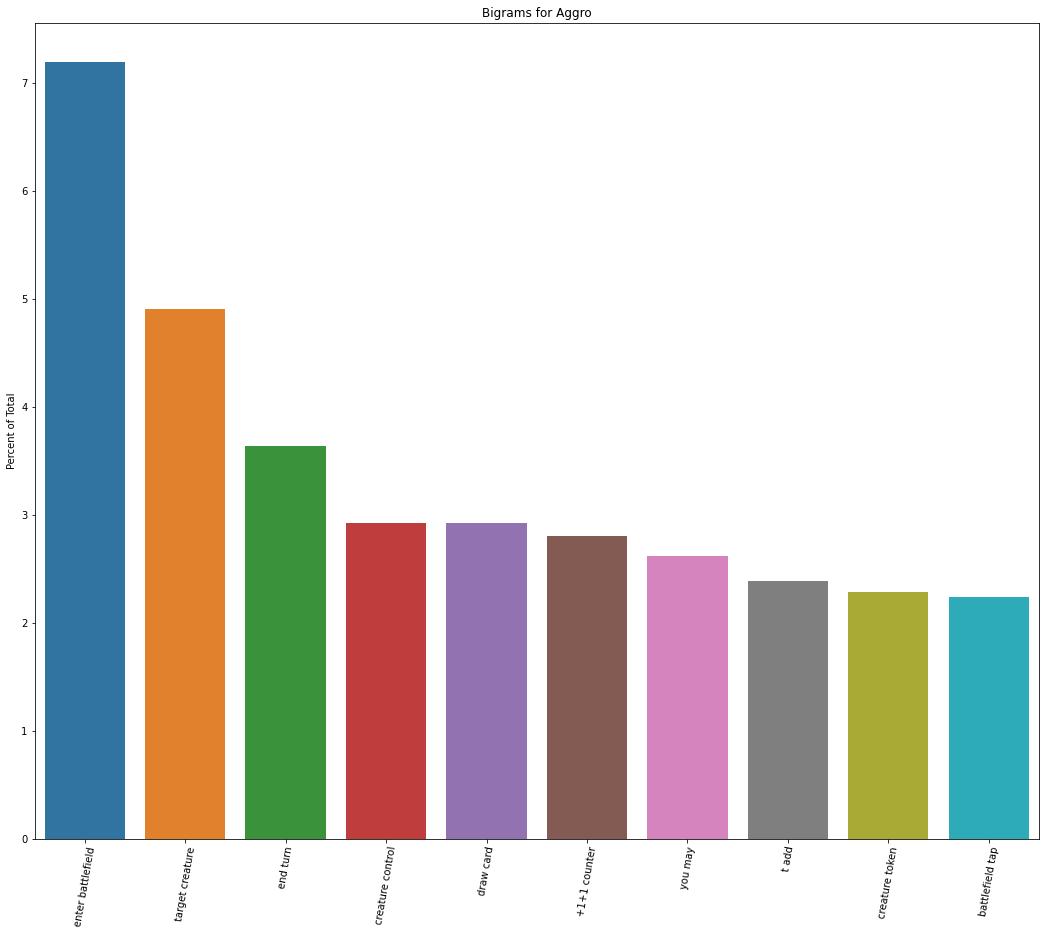

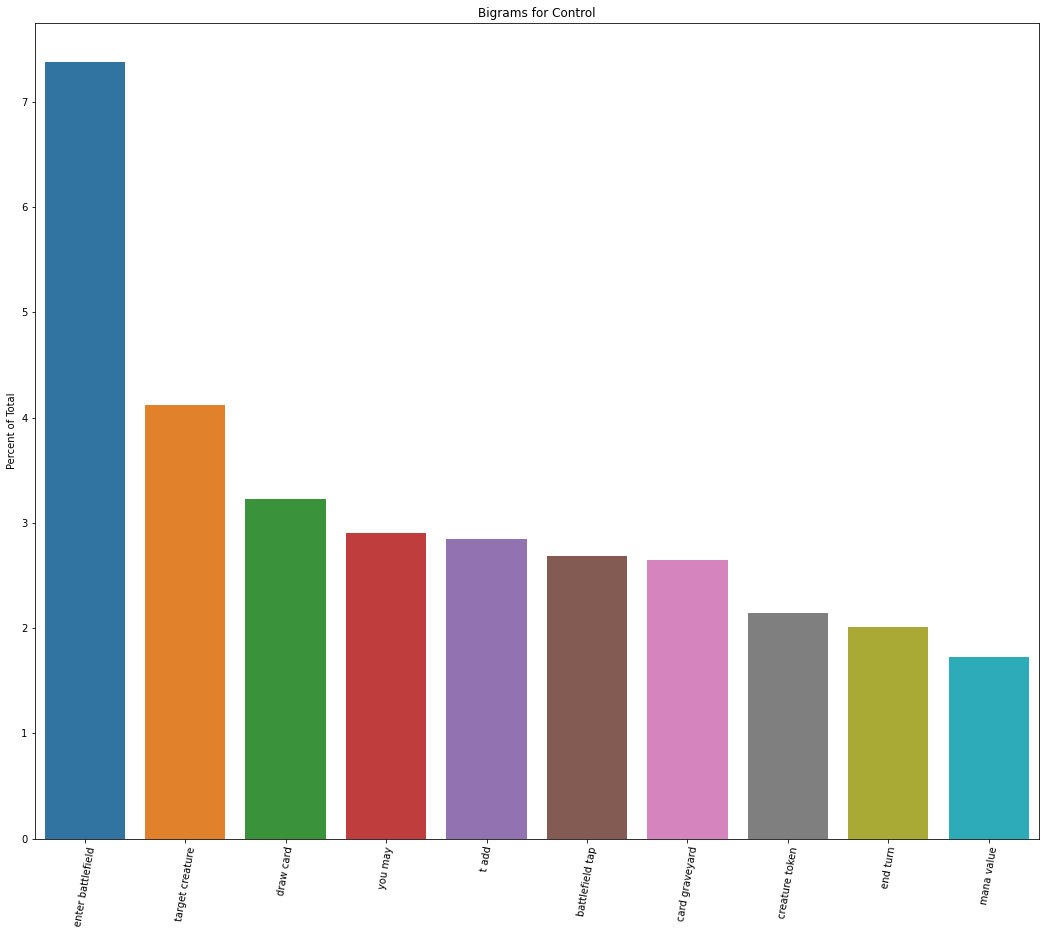

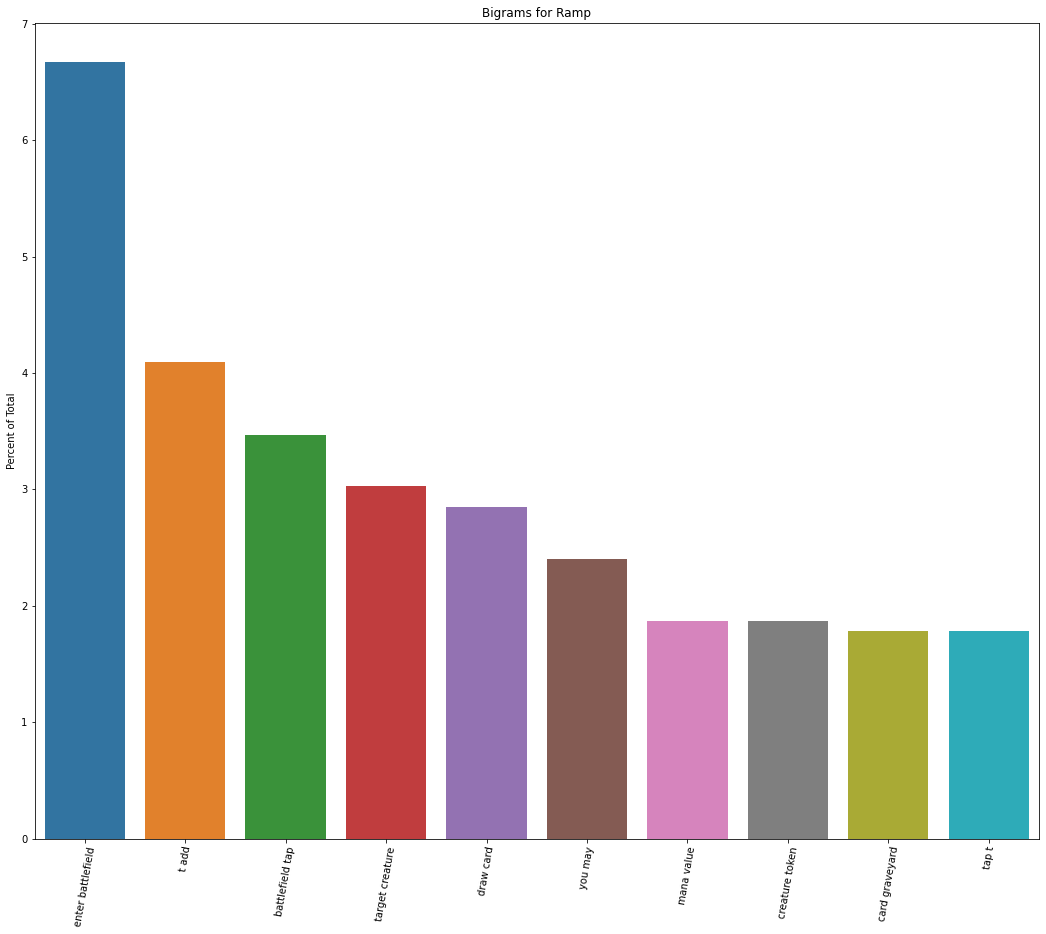

In [56]:
topn_analyze_card_text_by_archetype(main_decks, n=3, show=True)

In [57]:
full_table_oracle_text = oracle_text_analysis(full_table)

In [58]:
make_ngram_df(full_table_oracle_text["oracle_text"], 2)

,bigram,freq,pct_total
36,enter battlefield,457,6.738425
114,target creature,331,4.880566
42,end turn,224,3.302861
129,+1+1 counter,198,2.919493
83,you may,196,2.890003
49,draw card,193,2.845768
97,creature control,179,2.639339
78,creature token,154,2.270717
123,card graveyard,151,2.226482
0,t add,145,2.138012


In [59]:
all_card_bigrams = make_ngram_df(card_table["oracle_text"], 2)

In [60]:
tstat, pval = ttest_1samp(bigrams["freq"], np.mean(all_card_bigrams["freq"]))

In [61]:
pval

1.43425618101563e-101

In [61]:
def save_to_pdf():
    with PdfPages("MTG Viz.pdf") as pdf:
        most_winning_archetypes()
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors_by_set(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        topn_colors_archetypes(first_place_decks, n=3, pdf=pdf)
        plt.close("all")
        
        most_used_cards_graphics(main_decks)
        pdf.savefig()
        plt.close("all")
        
        topn_archetypes(main_decks, n=3, pdf=pdf)
        plt.close("all")
        
        topn_categories(main_decks, n=3, pdf=pdf)
        plt.close("all")
        
        cards_by_set(main_decks)
        pdf.savefig()
        plt.close("all")
        
        cards_by_set(main_decks, unique_cards=True)
        pdf.savefig()
        plt.close("all")
        
        number_of_decks_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        categories_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        archetypes_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        plot_color_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        plot_set_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        topn_analyze_card_text_by_archetype(main_decks, n=3, pdf=pdf)
        plt.close("all")

In [62]:
save_to_pdf()